In [863]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import networkx as nx
from scipy.optimize import minimize

import math
from torch_geometric import nn as gnn
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from IPython.display import clear_output

sns.set_style(style="whitegrid")

In [290]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [291]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [292]:
from dotenv import load_dotenv

load_dotenv()

from coral import DataSourceFactory
from core.models.datasource_type import DataSourceType
from core.models.protocol_type import ProtocolType
from service import EnvironmentSecretService

In [302]:
DEFAULT_DATASOUCE = DataSourceType.BYBIT
DEFAULT_SYMBOLS = ["AVAXUSDT"]
SLEEP_INTERVAL = 1
DOM = 10
EPS = np.finfo(float).eps
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [307]:
datasource = DataSourceFactory(EnvironmentSecretService())
datasource.register_rest_exchange(DEFAULT_DATASOUCE)

ds = datasource.create(DEFAULT_DATASOUCE, ProtocolType.REST)

In [308]:
symbols = ds.fetch_future_symbols()
symbol = [symbol for symbol in symbols if symbol.name in DEFAULT_SYMBOLS]

In [309]:
def plot_order_book(bids, asks, highlight_best=True):
    bids_df = pd.DataFrame(bids, columns=['price', 'quantity'])
    asks_df = pd.DataFrame(asks, columns=['price', 'quantity'])

    bids_df = bids_df.sort_values(by='price', ascending=False)
    asks_df = asks_df.sort_values(by='price', ascending=True)

    bids_df['cum_quantity'] = bids_df['quantity'].cumsum()
    asks_df['cum_quantity'] = asks_df['quantity'].cumsum()

    clear_output(wait=True)

    plt.figure(figsize=(14, 9))

    sns.lineplot(x=bids_df['price'], y=bids_df['cum_quantity'], label='Bids', color='green', linewidth=2)
    sns.lineplot(x=asks_df['price'], y=asks_df['cum_quantity'], label='Asks', color='red', linewidth=2)

    bid_imbalance = bids_df['cum_quantity'].max() - asks_df['cum_quantity'].mean()
    ask_imbalance = asks_df['cum_quantity'].max() - bids_df['cum_quantity'].mean()
    imbalance_threshold = (bid_imbalance + ask_imbalance) / 2

    plt.axhline(imbalance_threshold, color='orange', linestyle='--', label=f'Imbalance Threshold: {imbalance_threshold:.2f}')

    plt.fill_between(bids_df['price'], bids_df['cum_quantity'], color='green', alpha=0.3, step='mid')
    plt.fill_between(asks_df['price'], asks_df['cum_quantity'], color='red', alpha=0.3, step='mid')

    if highlight_best:
        best_bid = bids_df['price'].iloc[0]
        best_ask = asks_df['price'].iloc[0]

        plt.axvline(best_bid, color='green', linestyle='--', label=f'Best Bid: {best_bid:.2f}', linewidth=1.5)
        plt.axvline(best_ask, color='red', linestyle='--', label=f'Best Ask: {best_ask:.2f}', linewidth=1.5)

        mid_price = (best_bid + best_ask) / 2
        plt.axvline(mid_price, color='blue', linestyle=':', label=f'Mid Price: {mid_price:.2f}', linewidth=1.5)

    vwap_bid = (bids_df['price'] * bids_df['quantity']).sum() / bids_df['quantity'].sum()
    vwap_ask = (asks_df['price'] * asks_df['quantity']).sum() / asks_df['quantity'].sum()

    plt.axvline(vwap_bid, color='darkgreen', linestyle=':', label=f'VWAP Bid: {vwap_bid:.2f}', linewidth=1.2)
    plt.axvline(vwap_ask, color='darkred', linestyle=':', label=f'VWAP Ask: {vwap_ask:.2f}', linewidth=1.2)

    plt.xlabel('Price', fontsize=12)
    plt.ylabel('Cumulative Quantity', fontsize=12)
    plt.title('Order Book Depth Chart', fontsize=14)

    plt.legend(loc="upper right")

    plt.show()

In [1860]:
def plot_order_book(bids, asks):
    bids_df = pd.DataFrame(bids, columns=['price', 'quantity'])
    asks_df = pd.DataFrame(asks, columns=['price', 'quantity'])

    bids_df = bids_df.sort_values(by='price', ascending=False)
    asks_df = asks_df.sort_values(by='price', ascending=True)

    bids_df['cum_quantity'] = bids_df['quantity'].cumsum()
    asks_df['cum_quantity'] = asks_df['quantity'].cumsum()

    best_bid = bids_df['price'].iloc[0]
    best_ask = asks_df['price'].iloc[0]


    mid_price = (best_bid + best_ask) / 2

    spread = best_ask - best_bid
    mid_spread = spread / 2

    bids_df['relative_price'] = bids_df['price'] - best_bid - mid_spread
    asks_df['relative_price'] = asks_df['price'] - best_ask + mid_spread

    clear_output(wait=True)

    plt.figure(figsize=(14, 9))

    plt.bar(bids_df['relative_price'], -bids_df['cum_quantity'], color='green', label='Bids', width=spread/2, alpha=0.9)
    plt.bar(asks_df['relative_price'], asks_df['cum_quantity'], color='red', label='Asks', width=spread/2, alpha=0.9)

    plt.axvline(-mid_spread, color='green', linestyle='--', label=f'Best Bid: {best_bid:.2f}', linewidth=1.5)
    plt.axvline(0, color='blue', linestyle=':', label=f'Mid Price: {mid_price:.2f}', linewidth=1.5)
    plt.axvline(mid_spread, color='red', linestyle='--', label=f'Best Ask: {best_ask:.2f}', linewidth=1.5)

    plt.xlabel('Price Relative to Best Bid (Spread Divider)', fontsize=12)
    plt.ylabel('Cumulative Quantity (Depth)', fontsize=12)
    plt.title('Order Book Depth Bar Chart', fontsize=14)

    plt.legend(loc="upper right")
    plt.show()

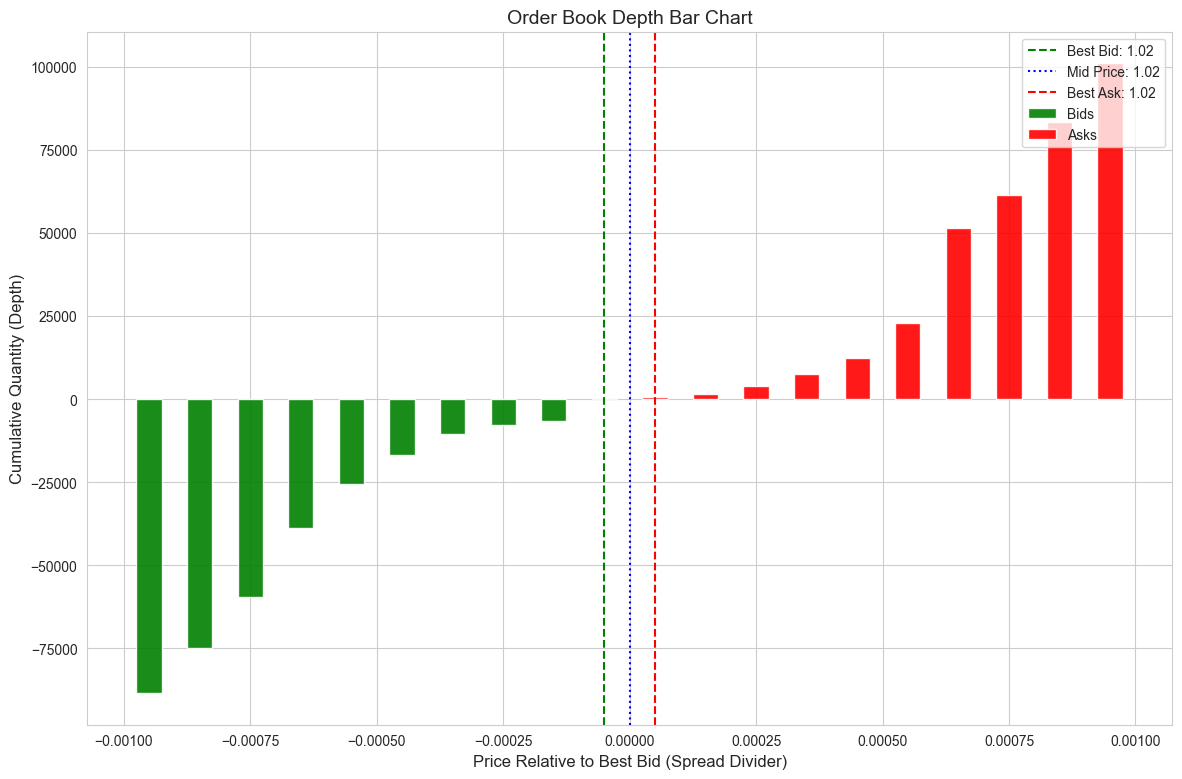

KeyboardInterrupt: 

In [211]:
while True:
    bids, asks, timestamp = ds.fetch_order_book(symbol[0], DOM)

    plot_order_book(np.array(bids), np.array(asks))

    time.sleep(SLEEP_INTERVAL)

In [34]:
def calculate_order_slices(symbol, total_size):
    x_min = symbol.min_position_size
    alpha = np.random.uniform(1.3, 1.5)

    while True:
        u = np.random.rand()

        order_size = x_min * (1 - u) ** (-1 / (alpha - 1))

        order_size = min(order_size, total_size)

        yield order_size

In [35]:
def plot_order_sizes(order_sizes):
    plt.figure(figsize=(10, 6))
    sns.histplot(order_sizes, bins=30, kde=False, color='blue', edgecolor='black', stat='density', alpha=0.6)
    plt.title('Distribution of Sampled Order Sizes')
    plt.xlabel('Order Size')
    plt.ylabel('Density')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

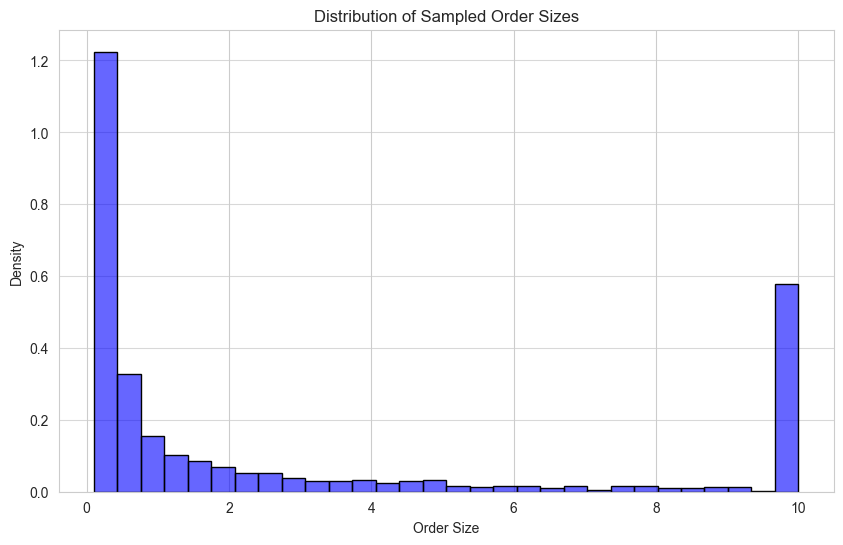

In [36]:
total_size = 10
num_samples = 1000

order_generator = calculate_order_slices(symbol=symbol[0], total_size=total_size)
order_sizes = [next(order_generator) for _ in range(num_samples)]

plot_order_sizes(order_sizes)


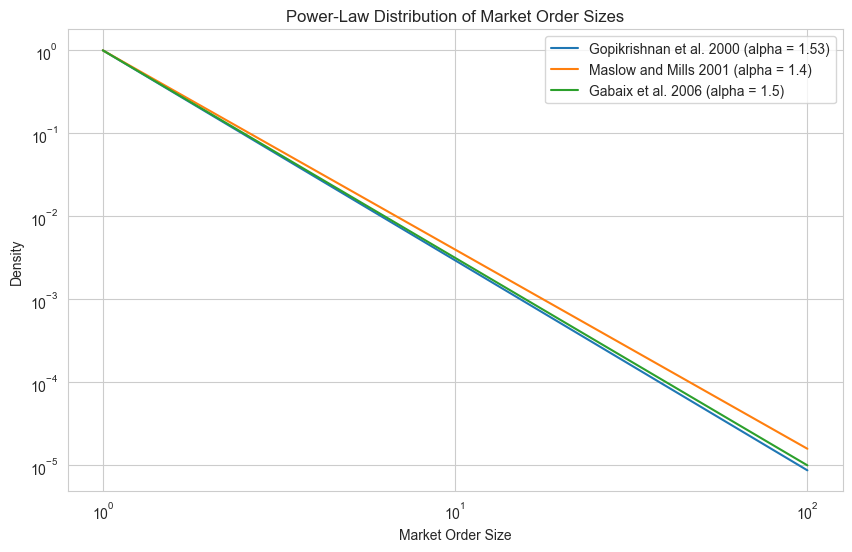

In [1285]:
def power_law_order_size(x, alpha):
    return x ** (-alpha - 1)

alpha_values = {
    "Gopikrishnan et al. 2000": 1.53,
    "Maslow and Mills 2001": 1.4,
    "Gabaix et al. 2006": 1.5
}

plt.figure(figsize=(10, 6))

x = np.linspace(1, 100, 500)

for label, alpha in alpha_values.items():
    y = power_law_order_size(x, alpha)
    plt.plot(x, y, label=f"{label} (alpha = {alpha})")

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Market Order Size")
plt.ylabel("Density")
plt.title("Power-Law Distribution of Market Order Sizes")
plt.legend()
plt.grid(True)
plt.show()

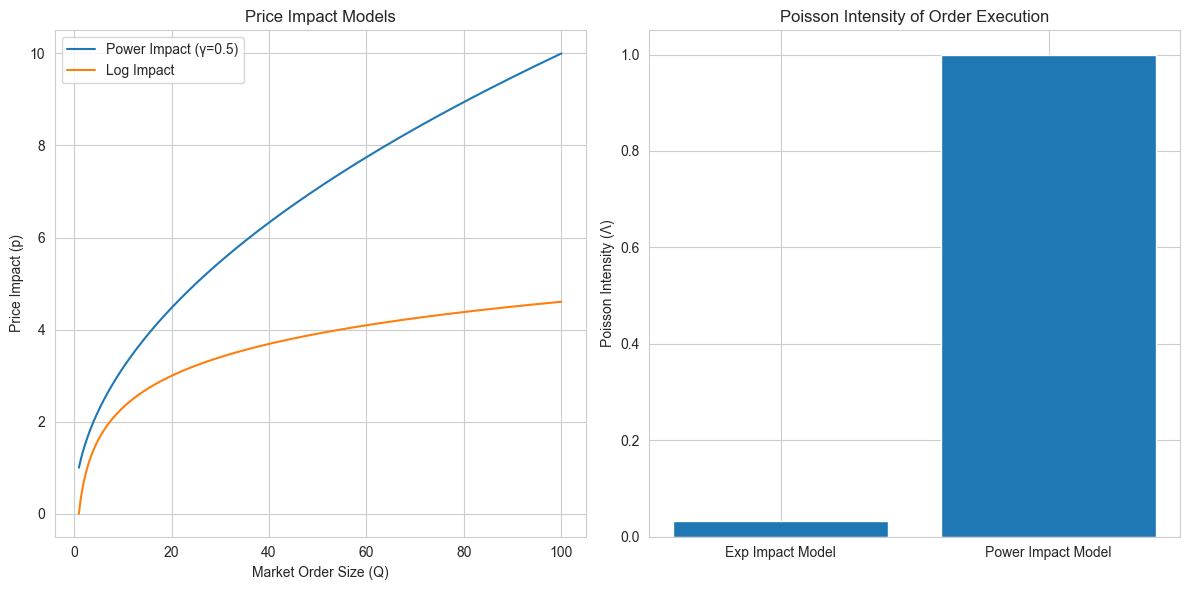

In [1286]:
alpha = 1.5
gamma_power = 0.5
gamma_log = 0.76

def price_impact_power(Q, gamma):
    return Q ** gamma

def price_impact_log(Q):
    return np.log(Q)

def poisson_intensity_exp_impact(K, alpha):
    A = 1 / alpha 
    k = alpha * K
    return A * np.exp(-k)

def poisson_intensity_power_impact(B, alpha, gamma):
    return B ** (-alpha / gamma)

Q = np.linspace(1, 100, 500)
K = 2

power_impact = price_impact_power(Q, gamma_power)
log_impact = price_impact_log(Q)

poisson_intensity_exp = poisson_intensity_exp_impact(K, alpha)
poisson_intensity_power = poisson_intensity_power_impact(1, alpha, gamma_power)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(Q, power_impact, label=f"Power Impact (γ={gamma_power})")
plt.plot(Q, log_impact, label="Log Impact")
plt.xlabel("Market Order Size (Q)")
plt.ylabel("Price Impact (p)")
plt.legend()
plt.title("Price Impact Models")

plt.subplot(1, 2, 2)
plt.bar(['Exp Impact Model', 'Power Impact Model'], [poisson_intensity_exp, poisson_intensity_power])
plt.ylabel("Poisson Intensity (Λ)")
plt.title("Poisson Intensity of Order Execution")

plt.tight_layout()
plt.show()

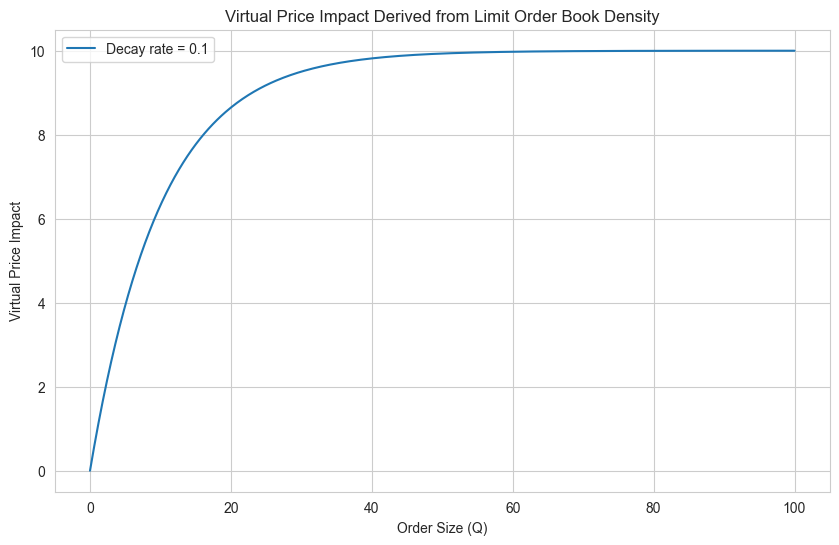

In [1287]:
from scipy.integrate import quad

def lob_density(x, decay_rate=0.1):
    return np.exp(-decay_rate * x)

def virtual_price_impact(Q, decay_rate=0.1):
    impact, _ = quad(lob_density, 0, Q, args=(decay_rate,))
    return impact

Q_values = np.linspace(0, 100, 500)
decay_rate = 0.1

virtual_impacts = [virtual_price_impact(Q, decay_rate) for Q in Q_values]

plt.figure(figsize=(10, 6))
plt.plot(Q_values, virtual_impacts, label=f"Decay rate = {decay_rate}")
plt.xlabel("Order Size (Q)")
plt.ylabel("Virtual Price Impact")
plt.title("Virtual Price Impact Derived from Limit Order Book Density")
plt.legend()
plt.grid(True)
plt.show()

In [310]:
SLEEP_INTERVAL = 8
ONE_HOUR = 3600
MULTI = 8
ORDER_BOOK_FILE = f'order_book_{symbol[0].name}_8h.csv'

In [311]:
def warm_up(symbol, DOM, duration=3600, sleep_interval=1):
    columns = ['timestamp'] + [item for i in range(1, DOM + 1) for item in [
        f'Ask {i} Price', 
        f'Ask {i} Size', 
        f'Bid {i} Price', 
        f'Bid {i} Size'
    ]]

    df = pd.DataFrame(columns=columns)

    start_time = time.time()
    end_time = start_time + duration

    while True:
        bids, asks, timestamp = ds.fetch_order_book(symbol, DOM)

        row = [timestamp]
        for i in range(DOM):
            row.extend([asks[i][0], asks[i][1], bids[i][0], bids[i][1]])

        df.loc[len(df)] = row

        time.sleep(sleep_interval)
        
        if time.time() > end_time:
            break

    return df

In [298]:
df = warm_up(symbol[0], DOM, ONE_HOUR * MULTI)

df.to_csv(ORDER_BOOK_FILE, index=False)

df.head()

Error: bybit GET https://api.bybit.com/v5/market/orderbook?symbol=XTZUSDT&category=linear&limit=10. Retrying...


,timestamp,Ask 1 Price,Ask 1 Size,Bid 1 Price,Bid 1 Size,Ask 2 Price,Ask 2 Size,Bid 2 Price,Bid 2 Size,Ask 3 Price,...,Bid 8 Price,Bid 8 Size,Ask 9 Price,Ask 9 Size,Bid 9 Price,Bid 9 Size,Ask 10 Price,Ask 10 Size,Bid 10 Price,Bid 10 Size
0,1.731119e+12,0.6596,1666.3,0.6594,0.8,0.6597,1145.9,0.6593,11.4,0.6598,...,0.6587,1821.6,0.6604,3300.8,0.6586,2263.8,0.6605,2758.6,0.6585,2642.0
1,1.731119e+12,0.6596,1666.9,0.6594,0.8,0.6597,1145.9,0.6593,11.4,0.6598,...,0.6587,1821.6,0.6604,3300.8,0.6586,2263.8,0.6605,2758.6,0.6585,2642.0
2,1.731119e+12,0.6596,1666.9,0.6594,0.8,0.6597,1145.9,0.6593,11.4,0.6598,...,0.6587,1821.6,0.6604,3300.8,0.6586,2263.8,0.6605,2758.6,0.6585,2642.0
3,1.731119e+12,0.6595,248.8,0.6594,0.8,0.6596,1666.9,0.6593,11.4,0.6597,...,0.6587,1821.6,0.6603,2905.6,0.6586,2263.8,0.6604,3300.8,0.6585,2642.0
4,1.731119e+12,0.6595,248.8,0.6594,0.8,0.6596,992.5,0.6593,11.4,0.6597,...,0.6587,1821.6,0.6603,2905.6,0.6586,2263.8,0.6604,3300.8,0.6585,2642.0


In [1454]:
def price_change(prev_price, current_price):
    if current_price > prev_price:
        return 'Uptick'
    elif current_price < prev_price:
        return 'Downtick'
    else:
        return 'No Change'

def determine_state(change_a, change_b):
    if change_a == 'Uptick' and change_b == 'Uptick':
        return 'Uptick'
    elif change_a == 'Uptick' and change_b == 'Downtick':
        return 'Reversal'
    elif change_a == 'Downtick' and change_b == 'Uptick':
        return 'Reversal'
    elif change_a == 'Downtick' and change_b == 'Downtick':
        return 'Downtick'

def ask_bid_states(df):
    df = df.copy()
    
    ask_states = []
    bid_states = []

    df['Ask Change'] = df['Ask 1 Price'].diff().apply(lambda x: 'Uptick' if x > 0 else ('Downtick' if x < 0 else 'Reversal'))
    df['Bid Change'] = df['Bid 1 Price'].diff().apply(lambda x: 'Uptick' if x > 0 else ('Downtick' if x < 0 else 'Reversal'))

    for i in range(2, len(df)):
        ask_change_1 = df['Ask Change'][i-2]
        ask_change_2 = df['Ask Change'][i-1]

        bid_change_1 = df['Bid Change'][i-2]
        bid_change_2 = df['Bid Change'][i-1]

        ask_states.append(determine_state(ask_change_1, ask_change_2))
        bid_states.append(determine_state(bid_change_1, bid_change_2))

    df['Ask State'] = pd.Series([None] + ask_states)
    df['Bid State'] = pd.Series([None] + bid_states)

    return df

In [1455]:
df = pd.read_csv(ORDER_BOOK_FILE)
df_states = ask_bid_states(df)

In [1456]:
aggr_ask = df_states.groupby('Ask State').agg(avg_ask_price=('Ask 1 Price', 'mean'), count_ask_state=('Ask State', 'size')).reset_index()
aggr_ask

,Ask State,avg_ask_price,count_ask_state
0,Downtick,24.858139,180
1,Reversal,24.867543,291
2,Uptick,24.872994,162


In [1457]:
aggr_bid = df_states.groupby('Bid State').agg(avg_bid_price=('Bid 1 Price', 'mean'), count_bid_state=('Bid State', 'size')).reset_index()
aggr_bid

,Bid State,avg_bid_price,count_bid_state
0,Downtick,24.853094,181
1,Reversal,24.862543,291
2,Uptick,24.867975,163


In [1460]:
from scipy.stats import chi2_contingency

def compute_transition_matrix(df, state_column):
    return pd.crosstab(df[state_column].shift(-1), df[state_column], dropna=True)

def chi_square_test(transition_matrix):
    chi2, p, _, _ = chi2_contingency(transition_matrix.fillna(0))
    return chi2, p

def print_chi_square_results(chi2, p, label):
    print(f"\nChi-Square Test for {label} State Transitions:")
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p}")
    
    if p > 0.05:
        print(f"The transitions for {label} are likely independent, which suggests that the process is Markovian.")
        print(f"Since the p-value is greater than 0.05, we fail to reject the null hypothesis of independence.")
        print(f"This implies the future state depends only on the current state, not the history of previous states.")
    else:
        print(f"The transitions for {label} are dependent, suggesting a non-Markovian process.")
        print(f"Since the p-value is less than 0.05, we reject the null hypothesis of independence.")
        print(f"This indicates that the process has memory and may be influenced by previous states or other factors.")

ask_transitions = compute_transition_matrix(df_states, 'Ask State')
bid_transitions = compute_transition_matrix(df_states, 'Bid State')

ask_chi2, ask_p = chi_square_test(ask_transitions)
bid_chi2, bid_p = chi_square_test(bid_transitions)

print(f"{ask_transitions}")
print_chi_square_results(ask_chi2, ask_p, 'Ask')

print(f"\n{bid_transitions}")
print_chi_square_results(bid_chi2, bid_p, 'Bid')

Ask State  Downtick  Reversal  Uptick
Ask State                            
Downtick         33        44       0
Reversal         41        54      35
Uptick            0        27      44

Chi-Square Test for Ask State Transitions:
Chi-Square Statistic: 81.46197627219142
P-value: 8.535230978606133e-17
The transitions for Ask are dependent, suggesting a non-Markovian process.
Since the p-value is less than 0.05, we reject the null hypothesis of independence.
This indicates that the process has memory and may be influenced by previous states or other factors.

Bid State  Downtick  Reversal  Uptick
Bid State                            
Downtick         33        44       0
Reversal         42        54      35
Uptick            0        28      44

Chi-Square Test for Bid State Transitions:
Chi-Square Statistic: 81.0536411854156
P-value: 1.041727500221204e-16
The transitions for Bid are dependent, suggesting a non-Markovian process.
Since the p-value is less than 0.05, we reject the nul

In [1485]:
def fe(df, k=8):
    df = df.copy()
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
   
    df['P'] = (df['Ask 1 Price'] + df['Bid 1 Price']) / 2
    
    df['PS'] = (df['Ask 1 Price'] - df['Bid 1 Price'])
    df['ESa'] = df['Ask 1 Price'] - df['P']
    df['ESb'] = df['P'] - df['Bid 1 Price']
    
    df['P+'] = df['P'].rolling(window=k).mean()
    df['P+'] = df['P+'].fillna(df['P'])

    df['d'] = (df['P+'] - df['P']) / df['P']
    
    df['R'] = (df['P'].shift(-1) - df['P']) / df['P']
    df['R'] = df['R'].fillna(0)
    
    df['D_B'] = df[[f'Bid {i} Size' for i in range(1, DOM + 1)]].sum(axis=1)
    df['D_A'] = df[[f'Ask {i} Size' for i in range(1, DOM + 1)]].sum(axis=1)

    df['V'] = df['D_B'] + df['D_A']

    df['DI'] = (df['D_B'] - df['D_A']) / (df['D_B'] + df['D_A'])

    df['BI'] = ((df['Bid 1 Price'] - df[f'Bid {DOM} Price']) - (df[f'Ask {DOM} Price'] - df['Ask 1 Price'])) / ((df['Bid 1 Price'] - df[f'Bid {DOM} Price']) + (df[f'Ask {DOM} Price'] - df['Ask 1 Price']))

    df['VI'] = (df['Bid 1 Size'] - df['Ask 1 Size']) / (df['Bid 1 Size'] + df['Ask 1 Size'])

    df['M'] = (df['Bid 1 Size'] / (df['Bid 1 Size'] + df['Ask 1 Size'])) * df['Ask 1 Price'] + (df['Ask 1 Size'] / (df['Bid 1 Size'] + df['Ask 1 Size'])) * df['Bid 1 Price']

    df['TR'] = pd.concat([
        df['PS'],
        (df['Ask 1 Price'] - df['P'].shift(1)).abs(),
        (df['Bid 1 Price'] - df['P'].shift(1)).abs()
    ], axis=1).max(axis=1)

    df['ATR'] = df['TR'].rolling(window=k).mean()
    df['ATR'] = df['ATR'].fillna(df['TR'])

    return df[['timestamp', 'P', 'M', 'PS', 'ESa', 'ESb',  'R', 'DI', 'BI', 'V', 'VI', 'ATR', 'd']]

df = pd.read_csv(ORDER_BOOK_FILE)

df_fe = fe(df)

df_fe.head(10)

,timestamp,P,M,PS,ESa,ESb,R,DI,BI,V,VI,ATR,d
0,2024-11-01 23:58:51.646,24.7875,24.785664,0.005,0.0025,0.0025,0.000000,0.164004,0.000000e+00,40536.3,-0.734379,0.005000,0.000000
1,2024-11-01 23:59:00.147,24.7875,24.785126,0.005,0.0025,0.0025,-0.000403,0.112261,0.000000e+00,38471.9,-0.949671,0.005000,0.000000
2,2024-11-01 23:59:08.746,24.7775,24.777484,0.005,0.0025,0.0025,0.000000,0.147797,0.000000e+00,38508.2,-0.006205,0.012500,0.000000
3,2024-11-01 23:59:17.047,24.7775,24.777523,0.005,0.0025,0.0025,0.000202,0.151567,0.000000e+00,38717.5,0.009377,0.005000,0.000000
4,2024-11-01 23:59:25.246,24.7825,24.781601,0.005,0.0025,0.0025,0.000000,0.099785,3.947460e-14,40537.0,-0.359788,0.007500,0.000000
5,2024-11-01 23:59:33.648,24.7825,24.781613,0.005,0.0025,0.0025,0.000000,0.105622,3.947460e-14,40887.4,-0.354806,0.005000,0.000000
6,2024-11-01 23:59:41.946,24.7825,24.780467,0.005,0.0025,0.0025,0.000000,0.098194,3.947460e-14,40105.3,-0.813020,0.005000,0.000000
7,2024-11-01 23:59:50.247,24.7825,24.780665,0.005,0.0025,0.0025,-0.000202,0.062082,3.947460e-14,38106.1,-0.734101,0.006250,0.000000
8,2024-11-01 23:59:58.546,24.7775,24.776181,0.005,0.0025,0.0025,-0.000404,0.088505,0.000000e+00,35170.8,-0.527458,0.006563,0.000151
9,2024-11-02 00:00:07.146,24.7675,24.765562,0.005,0.0025,0.0025,-0.000404,-0.036956,0.000000e+00,39733.4,-0.775175,0.007500,0.000454


In [1362]:
df_fe['PS'].describe()

count    3445.000000
mean        0.005004
std         0.000256
min         0.005000
25%         0.005000
50%         0.005000
75%         0.005000
max         0.020000
Name: PS, dtype: float64

In [1368]:
df_fe['ESa'].describe()

count    3445.000000
mean        0.002502
std         0.000128
min         0.002500
25%         0.002500
50%         0.002500
75%         0.002500
max         0.010000
Name: ESa, dtype: float64

In [1369]:
df_fe['ESb'].describe()

count    3445.000000
mean        0.002502
std         0.000128
min         0.002500
25%         0.002500
50%         0.002500
75%         0.002500
max         0.010000
Name: ESb, dtype: float64

In [1495]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    adf_result = adfuller(series.dropna())
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]
    

    if p_value < 0.05:
        result = "The series is likely stationary (reject null hypothesis)."
    else:
        result = "The series is likely non-stationary (fail to reject null hypothesis)."

    stationary = adf_statistic < critical_values['5%']
    
    return {
        'ADF Statistic': float(adf_statistic),
        'p-value': float(p_value),
        'Stationary': str(stationary),
        'Interpretation': result
    }

In [1496]:
check_stationarity(df_fe['P'])

{'ADF Statistic': -3.568793167329393,
 'p-value': 0.006386438926225439,
 'Stationary': 'True',
 'Interpretation': 'The series is likely stationary (reject null hypothesis).'}

In [1239]:
class IntensityDataset(Dataset):
    def __init__(self, df):        
        self.df = df.copy()

        event_times = self.df['timestamp'].to_numpy().astype(np.int64) // 10**6
        event_times = event_times - event_times[0]
        
        self.event_times_P = torch.tensor(event_times, dtype=torch.float32)
        self.event_times_BI = torch.tensor(event_times, dtype=torch.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        event_times_P = self.event_times_P[idx]
        event_times_BI = self.event_times_BI[idx]

        return [event_times_P, event_times_BI]

In [1289]:
hw_dataloader = DataLoader(IntensityDataset(df_fe), batch_size=8, shuffle=False)
next(iter(hw_dataloader))

[tensor([    0.,  8501., 17100., 25401., 33600., 42002., 50300., 58601.]),
 tensor([    0.,  8501., 17100., 25401., 33600., 42002., 50300., 58601.])]

In [1440]:
from abc import ABC, abstractmethod
from collections import deque
from typing import List, Optional

from torch import Tensor


class BaseKernel(ABC):
    BOUNDS = (1e-10, 1e10)

    @abstractmethod
    def coeff(self):
        pass

    @abstractmethod
    def intensity(self, t, event_times, mu):
        pass

    @abstractmethod
    def loss(self, mu, observed_events):
        pass

class HawkesExpKernel(BaseKernel):
    def __init__(self, alpha=0.5, beta=1.0, n_types = 1, dtype=torch.float32, device='cpu'):
        super().__init__()
        self.alpha = self._initialize_param(alpha, n_types, dtype, device)
        self.beta = self._initialize_param(beta, n_types, dtype, device)
        self._verify_params(n_types)

        self.n_types = n_types
        self.dtype = dtype
        self.device = device

    @property
    def coeff(self) -> List[Tensor]:
        return [self.alpha, self.beta]
    
    def _exp_intensity(self, t, event_times):
        time_diffs = t - event_times
        valid_mask = time_diffs > 0

        intensity = torch.zeros(self.n_types, dtype=self.dtype, device=self.device)

        for i in range(self.n_types):
            for j in range(self.n_types):
                valid_diffs = time_diffs[i, valid_mask[i, :]]

                if valid_diffs.numel() > 0:
                    exp_decay = torch.exp(-self.beta[i, j] * valid_diffs)
                    intensity[i] += self.alpha[i, j] * exp_decay.sum()
    
        return intensity

    def intensity(self, t, event_times, mu):
        event_times = self._process_events(event_times, self.dtype, self.device)
        intensity = mu + self._exp_intensity(t, event_times)
        return torch.clamp(intensity, min=self.BOUNDS[0], max=self.BOUNDS[1])
    
    def loss(self, mu: Tensor, observed_events: Tensor):
        event_times = self._process_events(observed_events, self.dtype, self.device)
        
        T_max = event_times[:, -1].max()
      
        lambda_vals = mu + self._exp_intensity(T_max, event_times)
        lambda_vals = torch.clamp(lambda_vals, min=self.BOUNDS[0], max=self.BOUNDS[1])

        ll = torch.sum(torch.log(lambda_vals + EPS))

        time_diffs = T_max - event_times

        decay_factors = (1 - torch.exp(-self.beta.unsqueeze(-1) * time_diffs.unsqueeze(1)))
        decay_term = (self.alpha / self.beta).unsqueeze(-1) * decay_factors

        integral_term = mu * T_max + decay_term.sum(dim=2)

        ll -= integral_term.sum()
        
        return -ll
    
    @staticmethod
    def _process_events(event_times, dtype, device):
        max_size = max(len(events) for events in event_times)
        ev = [torch.as_tensor(events, dtype=dtype, device=device) for events in event_times]
        ev = [torch.cat([tensor, torch.zeros(max_size - tensor.size(0), dtype=dtype, device=device)]) for tensor in ev]

        return torch.stack(ev)
    
    @staticmethod
    def _initialize_param(param, n_types, dtype, device) -> Tensor:
        if isinstance(param, (int, float)):
            return torch.full((n_types, n_types), fill_value=param, dtype=dtype, device=device)
        elif isinstance(param, list):
            return HawkesExpKernel._list_to_tensor(param, n_types, dtype, device)
        else:
            raise TypeError("Parameter must be a scalar or a list.")

    @staticmethod
    def _list_to_tensor(param, n_types, dtype, device) -> Tensor:
        if len(param) == 1:
            return torch.full((n_types, n_types), fill_value=param[0], dtype=dtype, device=device)
        elif len(param) == n_types * n_types:
            return torch.tensor(param, dtype=dtype, device=device).view(n_types, n_types)
        elif len(param) == n_types:
            return torch.tensor(param, dtype=dtype, device=device).repeat(n_types, 1)
        else:
            raise ValueError(f"Invalid parameter length: expected 1, {n_types}, or {n_types * n_types} but got {len(param)}.")


    def _verify_params(self, n_types):
        if self.alpha.shape != self.beta.shape:
            raise ValueError(f"Alpha and Beta must have the same shape, but got {self.alpha.shape} and {self.beta.shape}.")
        
        expected_size = n_types * n_types

        if self.alpha.numel() != expected_size:
            raise ValueError(f"Alpha parameter must have {expected_size} elements, but got {self.alpha.numel()}.")
        
        if self.beta.numel() != expected_size:
            raise ValueError(f"Beta parameter must have {expected_size} elements, but got {self.beta.numel()}.")

class HawkesSimulator:
    def __init__(self, baseline, kernel, max_history_size=2000, dtype=torch.float32, device='cpu'):
        self.kernel = kernel or HawkesExpKernel(n_types=1)
        self.baseline = self._init_baseline(baseline, self.kernel.n_types, dtype, device)
        self.n_types = self.kernel.n_types
        self.history = [deque(maxlen=max_history_size) for _ in range(self.n_types)]
        self.timestamps = [deque(maxlen=max_history_size) for _ in range(self.n_types)]
        self.max_history_size = max_history_size
        self.tracked_intensity = []
        self.intensity_tracked_times = []
        self.device = device
        self.dtype = dtype

    def warm_up(self, event_times):
        for event_type, events in enumerate(event_times):
            if not len(events):
                continue

            last_time = self.timestamps[event_type][-1] if self.timestamps[event_type] else events[0]
            relative_times = [event - last_time for event in events]
     
            self.history[event_type].extend(relative_times)
            self.timestamps[event_type].extend(events)

    def simulate(self, end_time, dt=0.01, max_iter=10000):
        curr_time = max((max(events) for events in self.history if len(events)), default=0.0)

        for _ in range(max_iter):
            intensities = self.kernel.intensity(curr_time, self.history, self.baseline)
            upper_bound_intensity = intensities.max().item() * 1.1

            x = torch.distributions.Exponential(rate=1 / upper_bound_intensity).sample().item()
            curr_time += x

            self.track_intensity(step=dt, T=curr_time)

            if curr_time >= end_time:
                break

            probas = intensities / upper_bound_intensity
            event_type = torch.multinomial(probas, 1).item()

            if torch.rand(1, dtype=self.dtype, device=self.device).item() <= probas[event_type]:
                self.timestamps[event_type].append(curr_time)
                self.history[event_type].append(curr_time)

                if len(self.history[event_type]) > self.max_history_size:
                    self.history[event_type].pop(0)

        self.track_intensity(step=dt, T=end_time)

    def track_intensity(self, step: float = 0.01, multi: float = 10.0, T: Optional[float] = None) -> None:
        t = self.intensity_tracked_times[-1] if self.intensity_tracked_times else (
            max([max(h) for h in self.history if len(h)], default=0.0) if self.history else 0.0
        )

        if T is None:
            T = t + step * multi

        while t < T:
            intensities = self.kernel.intensity(t, self.history, self.baseline)
            self.tracked_intensity.append([i.detach().cpu() for i in intensities])
            self.intensity_tracked_times.append(t)
            t += step

    def reset(self):
        self.history = [[] for _ in range(self.n_types)]
        self.timestamps = [[] for _ in range(self.n_types)]
        self.tracked_intensity.clear()
        self.intensity_tracked_times.clear()

    def plot_intensity(self):
        import matplotlib.pyplot as plt
        _, (ax_intensity, ax_events) = plt.subplots(
            2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(16, 4)
        )

        for i, intensity in enumerate(zip(*self.tracked_intensity)):
            ax_intensity.plot(self.intensity_tracked_times, intensity, label=f"Intensity Type {i}", alpha=0.7)

        ax_intensity.set_ylabel("Intensity")
        ax_intensity.legend(loc="upper right")
        ax_intensity.grid(True)

        for i, event_times in enumerate(self.timestamps):
            ax_events.scatter(event_times, [i] * len(event_times), marker="o", alpha=0.5, label=f"Events Type {i}")

        ax_events.set_ylim(-0.5, len(self.baseline) - 0.5)
        ax_events.set_yticks(range(len(self.baseline)))
        ax_events.set_yticklabels([f"Type {i}" for i in range(len(self.baseline))])
        ax_events.set_xlabel("Time")
        ax_events.legend(loc="upper right")
        ax_events.grid(True)

        plt.suptitle("Hawkes Process Intensity and Events")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    @staticmethod
    def _init_baseline(baseline, n_types, dtype, device):
        if isinstance(baseline, torch.Tensor):
            if baseline.numel() == 1:
                return baseline.expand(n_types).to(dtype=dtype, device=device)
            elif baseline.numel() == n_types:
                return baseline.to(dtype=dtype, device=device)
            else:
                raise ValueError(f"Tensor size {baseline.numel()} does not match n_types {n_types}")
        elif isinstance(baseline, (int, float)):
            return torch.tensor([baseline] * n_types, dtype=dtype, device=device)
        elif isinstance(baseline, list):
            if len(baseline) == n_types:
                return torch.tensor(baseline, dtype=dtype, device=device)
            else:
                raise ValueError(f"List length {len(baseline)} does not match n_types {n_types}")
        else:
            raise ValueError(f"Unsupported baseline type: {type(baseline)}")

class HawkesInference:
    def __init__(self, mu=0.1, l1=1e-4, l2=1e-4, elastic_net_ratio=0.95, dtype=torch.float32, device='cpu'):
        self.mu = mu
        self.kernel = None
        self.sim = None

        self.l1 = l1
        self.l2 = l2
        self.elastic_net_ratio = elastic_net_ratio

        self.dtype = dtype
        self.device = device
        self.parameters = nn.ParameterList()

        self.best_loss = float('inf')
        self.best_parameters = None

        self.set_kernel(HawkesExpKernel())

    @property
    def baseline(self):
        if self.best_parameters is not None:
            return self.best_parameters[0].detach().cpu().numpy()
        return self.sim.baseline.detach().cpu().numpy()
    
    @property
    def coeff(self):
        if self.best_parameters is not None:
            return [param.detach().cpu().numpy() for param in self.best_parameters[1:]]
        return [param.detach().cpu().numpy() for param in self.parameters[1:]]
    
    def set_kernel(self, kernel: BaseKernel):
        self.kernel = kernel
        self.sim = HawkesSimulator(self.mu, kernel=self.kernel, dtype=self.dtype, device=self.device)
        self.parameters = nn.ParameterList([nn.Parameter(param) for param in [self.sim.baseline] + self.kernel.coeff])

    def _reg(self):
        l1_penalty = self.l1 * sum(torch.abs(param) for param in self.parameters)
        l2_penalty = self.l2 * sum(torch.square(param) for param in self.parameters)

        reg = (self.elastic_net_ratio * l1_penalty) + ((1 - self.elastic_net_ratio) * l2_penalty)
        reg = torch.sum(reg)

        return reg

    def fit(self, dataloader: DataLoader, epoch=900, lr=1e-5, accum=2):
        optimizer = torch.optim.Adam(self.parameters, lr=lr)

        for i in range(epoch):
            optimizer.zero_grad()
            total_loss = torch.tensor(0.0, requires_grad=True, dtype=self.dtype, device=self.device)

            for batch_idx, batch_events in enumerate(dataloader):
                ll = self.kernel.loss(self.sim.baseline, batch_events)
                reg = self._reg()
                
                batch_loss = ll + reg
                total_loss = total_loss + batch_loss

                if (batch_idx + 1) % accum == 0:
                    total_loss.backward()
                
                    optimizer.step()
                    optimizer.zero_grad()
                    total_loss = torch.tensor(0.0, requires_grad=True, dtype=self.dtype, device=self.device)

            if total_loss.item() >= 0 and total_loss.item() < self.best_loss:
                self.best_loss = total_loss.item()
                self.best_parameters = [param.clone().detach() for param in self.parameters]

            if total_loss.item() < 0:
                break

            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {total_loss.item()}, Baseline: {self.baseline}, Coeff: {self.coeff} ")

    def warm_up(self, event_times):
        self.sim.warm_up(event_times)

    def forecast(self, forecast=5.0, dt=0.1):
        self.sim.simulate(forecast, dt)

        future_intensities = self.sim.tracked_intensity
        future_intensity_times = self.sim.intensity_tracked_times
        
        return future_intensities, future_intensity_times


In [1319]:
hwinf = HawkesInference()
hwinf.set_kernel(HawkesExpKernel(n_types=2))
hwinf.coeff

[array([[0.5, 0.5],
        [0.5, 0.5]], dtype=float32),
 array([[1., 1.],
        [1., 1.]], dtype=float32)]

In [1320]:
hwinf.fit(hw_dataloader, epoch=1000)
hwinf.coeff

Iteration 0, Loss: 11271074.0, Baseline: [0.09785029 0.09785029], Coeff: [array([[0.4978479, 0.4978479],
       [0.4978479, 0.4978479]], dtype=float32), array([[0.9978471, 0.9978471],
       [0.9978471, 0.9978471]], dtype=float32)] 
Iteration 10, Loss: 8795933.0, Baseline: [0.07636222 0.07636222], Coeff: [array([[0.4763828, 0.4763828],
       [0.4763828, 0.4763828]], dtype=float32), array([[0.9763179, 0.9763179],
       [0.9763179, 0.9763179]], dtype=float32)] 
Iteration 20, Loss: 6321589.5, Baseline: [0.05488108 0.05488108], Coeff: [array([[0.45491767, 0.45491767],
       [0.45491767, 0.45491767]], dtype=float32), array([[0.9547887, 0.9547887],
       [0.9547887, 0.9547887]], dtype=float32)] 
Iteration 30, Loss: 3847246.5, Baseline: [0.03339994 0.03339994], Coeff: [array([[0.43345255, 0.43345255],
       [0.43345255, 0.43345255]], dtype=float32), array([[0.9332595, 0.9332595],
       [0.9332595, 0.9332595]], dtype=float32)] 
Iteration 40, Loss: 1373329.375, Baseline: [0.01192249 0.011

[array([[0.40125486, 0.40125486],
        [0.40125486, 0.40125486]], dtype=float32),
 array([[0.9009657, 0.9009657],
        [0.9009657, 0.9009657]], dtype=float32)]

In [1394]:
T_sim = 16
mu = hwinf.baseline.tolist()
alpha = np.diagonal(hwinf.coeff[0]).tolist()
beta = np.diagonal(hwinf.coeff[1]).tolist()

print(f"Baseline: {mu}\nExcitation: {alpha}\nDecay: {beta}\n")

dt = 0.1
n_types = 2

kernel = HawkesExpKernel(alpha=alpha, beta=beta, n_types=2)
sim = HawkesSimulator(baseline=mu, kernel=kernel)

print(f"Kernel: {kernel.__class__.__name__} \nExcitation: {kernel.alpha}\nDecay: {kernel.beta}\n")

for i in range(0, 120, 32):
    sim.simulate(T_sim + i, dt)

print(f"Event Types: {len(sim.timestamps)}, Intensity: {len(sim.tracked_intensity)}")


Baseline: [0.0011839286889880896, 0.0011839286889880896]
Excitation: [0.4012548625469208, 0.4012548625469208]
Decay: [0.900965690612793, 0.900965690612793]

Kernel: HawkesExpKernel 
Excitation: tensor([[0.4013, 0.4013],
        [0.4013, 0.4013]])
Decay: tensor([[0.9010, 0.9010],
        [0.9010, 0.9010]])

Event Types: 2, Intensity: 1255


In [927]:
kernel.loss(sim.baseline, torch.tensor([[0.2, 0.3, 0.3, 0.7], [0.1, 0.2, 0.1, 0.3]]))

tensor(3.0250, grad_fn=<NegBackward0>)

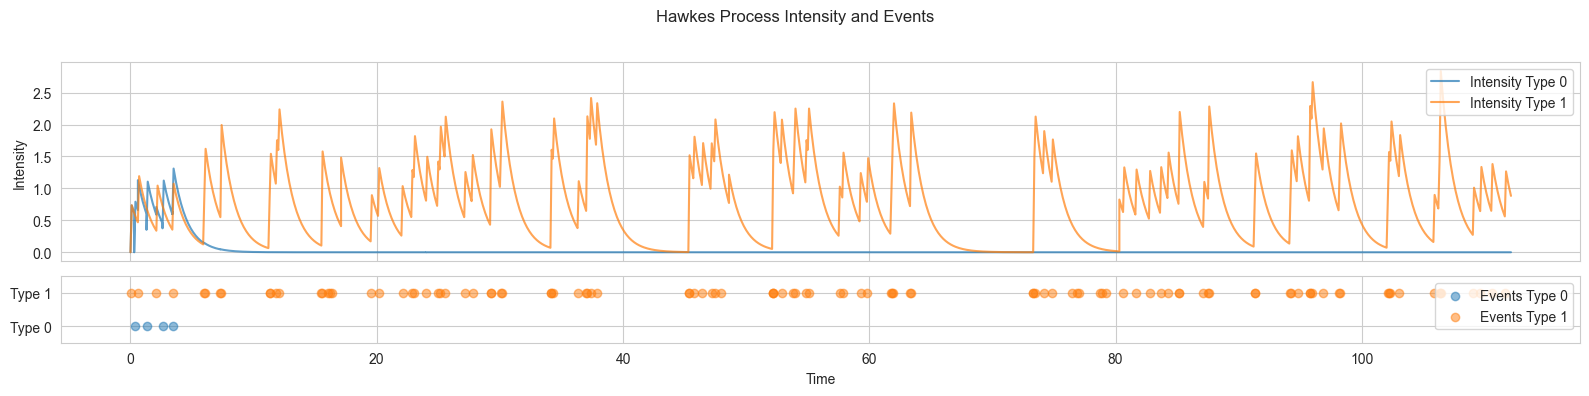

In [1389]:
sim.plot_intensity()

In [1453]:
FORECAST = 5 # seconds
WARM_UP = 2 # seconds
STEP = 0.5
SLEEP_INTERVAL = 0.1
N = 3

hwfor = HawkesInference(mu=mu[0])
hwfor.set_kernel(kernel)

def get_last_n_intensities(future_intensities, future_intensity_times, curr_time, n):
    valid_indices = [i for i, time in enumerate(future_intensity_times) if time <= curr_time]
    num_to_return = min(n, len(valid_indices))

    event_intensities = []

    for intensities in zip(*future_intensities):
        event_type_intensities = [ev.item() for ev in intensities]
        event_intensities.append([event_type_intensities[i] for i in valid_indices[-num_to_return:]])
        return event_intensities

while True:
    df = fe(warm_up(symbol[0], DOM, WARM_UP, SLEEP_INTERVAL))

    event_times = df['timestamp'].to_numpy().astype(np.int64) // 10**6
    hwfor.warm_up([event_times, event_times])

    intensity_values, intensity_times = hwfor.forecast(FORECAST, STEP)
    
    intensity = get_last_n_intensities(intensity_values, intensity_times, event_times[-1], N)

    print(intensity[0])


[0.0011839286889880896]
[0.0011839286889880896, 0.0011839286889880896, 0.0011839286889880896]
[0.0011839286889880896, 0.0011839286889880896, 0.0011839286889880896]


KeyboardInterrupt: 

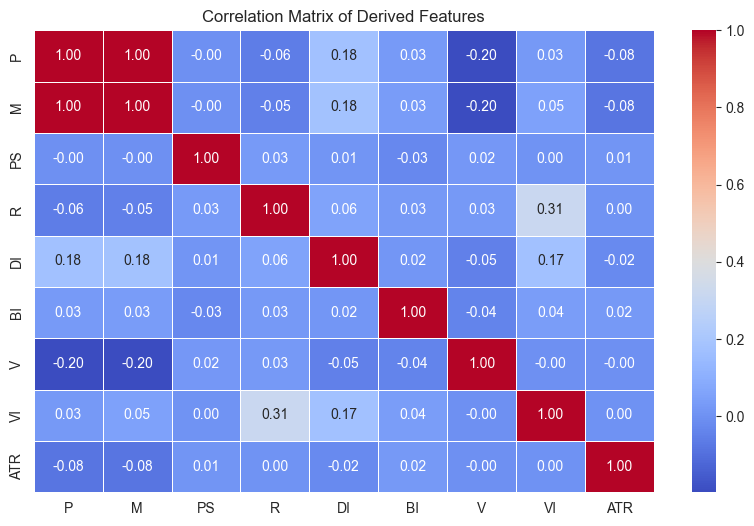

In [1470]:
def plot_correlation_matrix(df):
    plt.figure(figsize=(10, 6))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix of Derived Features")
    plt.show()

plot_correlation_matrix(df_fe.drop(columns=['timestamp', 'd', 'ESa', 'ESb']))

In [1471]:
def label_data(df, alpha):
    df = df.copy()
    df['y'] = np.where(df['d'] > alpha, 1, np.where(df['d'] < -alpha, -1, 0))
    return df

def plot_label_distribution(df):
    label_counts = df['y'].value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1]})
    
    sns.barplot(ax=axes[0], x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="viridis", dodge=False)
    axes[0].set_title('Class Distribution of Labels')
    axes[0].set_xlabel('Class Labels')
    axes[0].set_ylabel('Frequency')
    axes[0].legend(title="Labels", loc="upper right")
    
    sns.kdeplot(ax=axes[1], data=df, x='y', fill=True, alpha=0.5)
    axes[1].set_title('KDE Plot of Label Density')
    axes[1].set_xlabel('Class Labels')
    axes[1].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

In [1472]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

best_alpha = None
best_imbalance_ratio = float('inf')

BIG_NUM = 1e10
NEUTRAL_PENALTY_WEIGHT = 0.15

def calculate_imbalance_ratio(label_counts):
    positive_count = label_counts.get(1, 0)
    negative_count = label_counts.get(-1, 0)
    neutral_count = label_counts.get(0, 0)
    total_count = positive_count + negative_count + neutral_count
    
    if total_count == 0:
        return BIG_NUM

    weight_pos = positive_count / total_count
    weight_neg = negative_count / total_count
    weight_neutral = neutral_count / total_count
    
    neutral_penalty = weight_neutral ** 2

    if positive_count == 0 or negative_count == 0:
        balance_penalty = BIG_NUM
    else:
        balance_penalty = (abs(weight_pos - weight_neg)) ** 2
    
    return min(balance_penalty + NEUTRAL_PENALTY_WEIGHT * neutral_penalty, BIG_NUM)

search_space = [Real(1e-6, 1e-2, "log-uniform", name="alpha")]

@use_named_args(search_space)
def optimize_alpha(alpha):
    df_l = label_data(df_fe, alpha)
    label_counts = df_l['y'].value_counts()
    imbalance_ratio = calculate_imbalance_ratio(label_counts)
    
    if np.isinf(imbalance_ratio) or np.isnan(imbalance_ratio):
        imbalance_ratio = BIG_NUM

    return imbalance_ratio

result = gp_minimize(
    func=optimize_alpha,
    dimensions=search_space,
    n_calls=50,
    n_random_starts=5,
    acq_func="EI",
    random_state=seed
)

best_alpha = result.x[0]
best_imbalance_ratio = result.fun

print(f"Best alpha: {best_alpha}")
print(f"Best imbalance ratio: {best_imbalance_ratio}")

Best alpha: 7.085175249502597e-06
Best imbalance ratio: 0.0005342211530562158


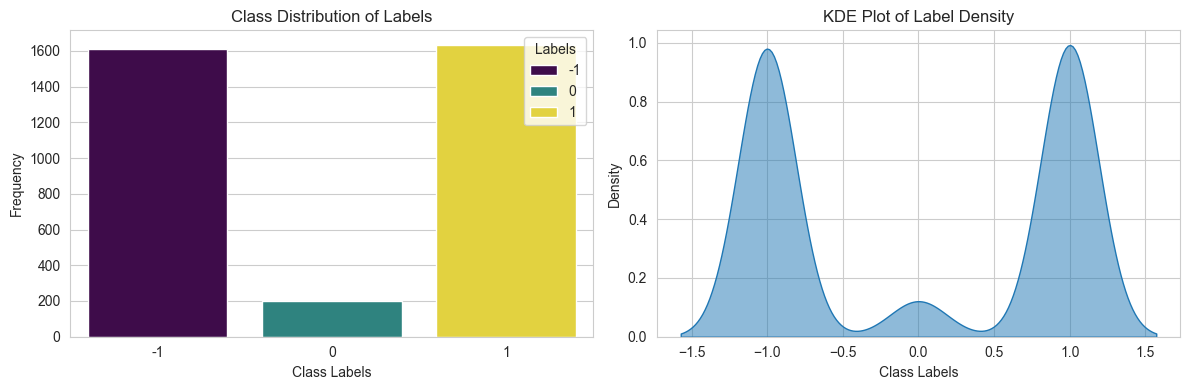

In [1473]:
df_l = label_data(df_fe, best_alpha)

plot_label_distribution(df_l)

In [1474]:
k = 10

def normalize(X, features):
    X_normalized = X.copy()
    means = {}
    stds = {}

    for col in features:
        rolling_mean = X[col].rolling(window=k).mean()
        rolling_std = X[col].rolling(window=k).std()
        
        means[col] = rolling_mean
        stds[col] = rolling_std

        X_normalized[col] = (X[col] - rolling_mean) / (rolling_std + EPS)

    X_normalized = X_normalized.dropna()

    return X_normalized, means, stds

def denormalize(X_normalized, means, stds, features):
    X_denormalized = X_normalized.copy()

    for col in features:
        X_denormalized[col] = (X_normalized[col] * (stds[col] + EPS)) + means[col]

    return X_denormalized

In [1475]:
from sklearn.calibration import expit, label_binarize
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, hamming_loss
from imblearn.under_sampling import NeighbourhoodCleaningRule

def sigmoid_fn(preds):
    m, c = np.polyfit(preds, np.log(preds / (1 - preds)), 1)
    return expit(m * preds + c)

def sigmoid_calibration(y_proba):
    return np.apply_along_axis(sigmoid_fn, 0, y_proba)

def isotonic_calibration(y_proba, y_test, classes):
    n_samples, n_classes = y_proba.shape
    calibrated_probs = np.zeros((n_samples, n_classes))
    y_binarized = label_binarize(y_test, classes=classes)

    for i, _ in enumerate(classes):
        class_preds = y_proba[:, i]
        calibrator = IsotonicRegression(out_of_bounds="clip")
        calibrator.fit(class_preds, y_binarized[:, i])
        calibrated_probs[:, i] = calibrator.predict(class_preds)

    return calibrated_probs

def venn_abers_calibration(y_proba, y_test, classes):
    n_samples, n_classes = y_proba.shape
    calibrated_probs = np.zeros((n_samples, n_classes))
    y_binarized = label_binarize(y_test, classes=classes)

    for i, _ in enumerate(classes):
        class_preds = y_proba[:, i]
        
        calibrator_lower = IsotonicRegression(out_of_bounds="clip")
        calibrator_lower.fit(class_preds, y_binarized[:, i])
        lower_bound = calibrator_lower.predict(class_preds)

        calibrator_upper = IsotonicRegression(out_of_bounds="clip")
        calibrator_upper.fit(1 - class_preds, 1 - y_binarized[:, i])
        upper_bound = 1 - calibrator_upper.predict(1 - class_preds)

        calibrated_probs[:, i] = np.sqrt(lower_bound * upper_bound)

    return calibrated_probs

def calibrate_probabilities(y_predict_proba, y_test, classes, calibration_method):
    if calibration_method == 'venn_abers':
        return venn_abers_calibration(y_predict_proba, y_test, classes)
    elif calibration_method == 'isotonic':
        return isotonic_calibration(y_predict_proba, y_test, classes)
    elif calibration_method == 'sigmoid':
        return sigmoid_calibration(y_predict_proba)
    else:
        raise ValueError("Unsupported calibration method.")

def perform_kfold_cv(model, X, y, k_folds=5, calibration_method='venn_abers'):
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
    classes = np.unique(y)
    probabilities = np.zeros((len(y), len(classes)))
    predictions = np.zeros(len(y))
    true_labels = np.zeros(len(y))

    for train_index, test_index in kf.split(X, y):
        X_train_full, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test = y.iloc[train_index], y.iloc[test_index]

        sampler = NeighbourhoodCleaningRule()

        X_train_sampled, y_train_sampled = sampler.fit_resample(X_train_full, y_train_full)

        model.fit(X_train_sampled, y_train_sampled)

        y_predict_proba = model.predict_proba(X_test)

        calibrated_probs = calibrate_probabilities(y_predict_proba, y_test, classes, calibration_method)

        predictions[test_index] = classes[np.argmax(calibrated_probs, axis=1)]
        probabilities[test_index] = calibrated_probs

        true_labels[test_index] = y_test.values

    return predictions, probabilities, true_labels

def calculate_metrics(predictions, probabilities, y_true):
    y_true_binarized = label_binarize(y_true, classes=[-1, 0, 1])

    def brier_loss_calc(y_true, pred):
        return ((y_true - pred)**2).mean()

    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_true, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_true, predictions, average='weighted', zero_division=0)
    brier = brier_loss_calc(y_true, predictions)
    roc_auc = roc_auc_score(y_true_binarized, probabilities, average='weighted', multi_class='ovr')
    hamming = hamming_loss(y_true, predictions)

    return accuracy, precision, recall, f1, brier, roc_auc, hamming

def plot_regime(df, model_name):
    plt.figure(figsize=(16, 8))

    plt.plot(df['timestamp'], df['P'], color='gray', alpha=0.5, label='Feature P')

    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == 1), 
                    color='green', alpha=0.3, label='Long')
    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == -1), 
                    color='red', alpha=0.3, label='Short')
    
    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == 0), 
                    color='blue', alpha=0.3, label='Range')

    plt.title(f'({model_name}) P and Regime')
    plt.xlabel('TS')
    plt.ylabel('P')
    plt.legend()
    plt.grid()

    plt.show()

def plot_roc_auc(probabilities, true_labels):
    y_test_bin = label_binarize(true_labels,  classes=[-1, 0, 1])
    
    roc_auc = roc_auc_score(y_test_bin, probabilities, average='macro', multi_class='ovr')

    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], probabilities[:, i])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    plt.figure(figsize=(8, 5))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [1476]:
features = ['P', 'PS', 'R', 'DI', 'BI', 'VI', 'V', 'ATR']

X = df_l[features]
y = df_l['y']

X_normalized, X_means, X_stds = normalize(X, features)

y = y.loc[X_normalized.index]

timestamps = pd.to_datetime(df_l.loc[X_normalized.index]['timestamp'], unit='ms')


Accuracy: 0.9243
Precision: 0.9079
Recall: 0.9243
F1 Score: 0.9077
Brier Score: 0.1394
ROC-AUC Score: 0.9838
Hamming: 0.0757


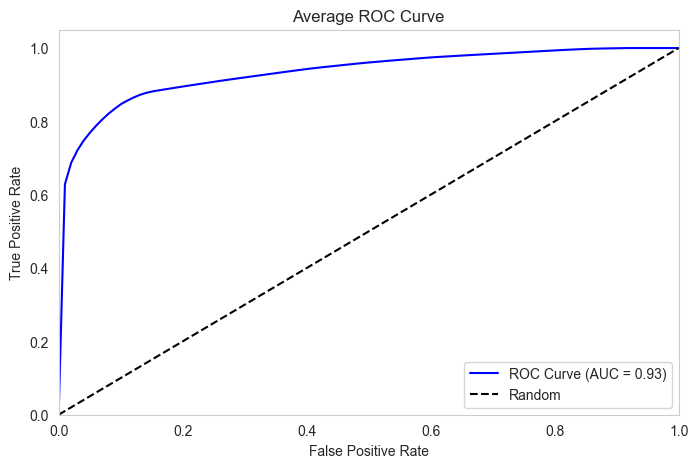

In [1477]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

k_folds = 5
calibration = 'venn_abers'

model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', random_state=seed))

predictions, probabilities, true_labels = perform_kfold_cv(model, X_normalized, y, k_folds, calibration)

accuracy, precision, recall, f1, brier, roc_auc, hamming = calculate_metrics(predictions, probabilities, true_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Hamming: {hamming:.4f}")

plot_roc_auc(probabilities, true_labels)

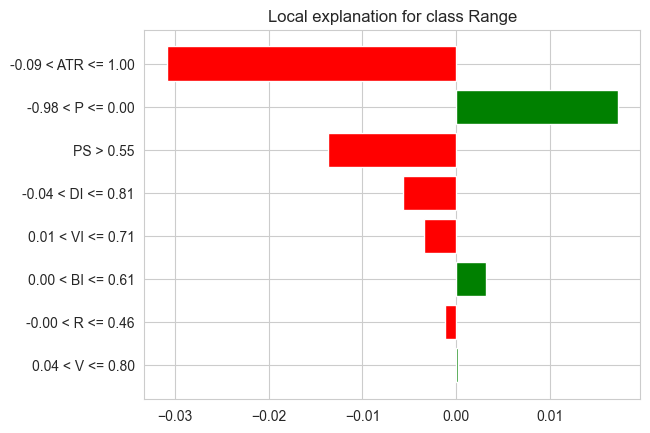

In [1483]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(X_normalized.values, mode="classification", 
                                      feature_names=features, class_names=['Short', 'Range', 'Long'], 
                                      discretize_continuous=True)

def lime_predict_proba(data):
    data_df = pd.DataFrame(data, columns=features)
    return model.predict_proba(data_df)

random_index = np.random.randint(0, len(X_normalized))
exp = lime_explainer.explain_instance(X_normalized.iloc[random_index].values, lime_predict_proba, num_features=len(features))

exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

plt.show()

In [1479]:
from sklearn.ensemble import RandomForestClassifier

k_folds = 5

rf_model = RandomForestClassifier(random_state=seed)

perform_kfold_cv(rf_model, X_normalized, y, k_folds)

rf_imp = pd.DataFrame({
    "feature": X_normalized.columns,
    "importance": rf_model.feature_importances_
})

rf_imp = rf_imp.sort_values(by="importance", ascending=False).reset_index(drop=True)

rf_imp.head(10)

,feature,importance
0,P,0.657136
1,R,0.106886
2,DI,0.090896
3,ATR,0.034298
4,V,0.030778
5,VI,0.029245
6,BI,0.027197
7,PS,0.023565


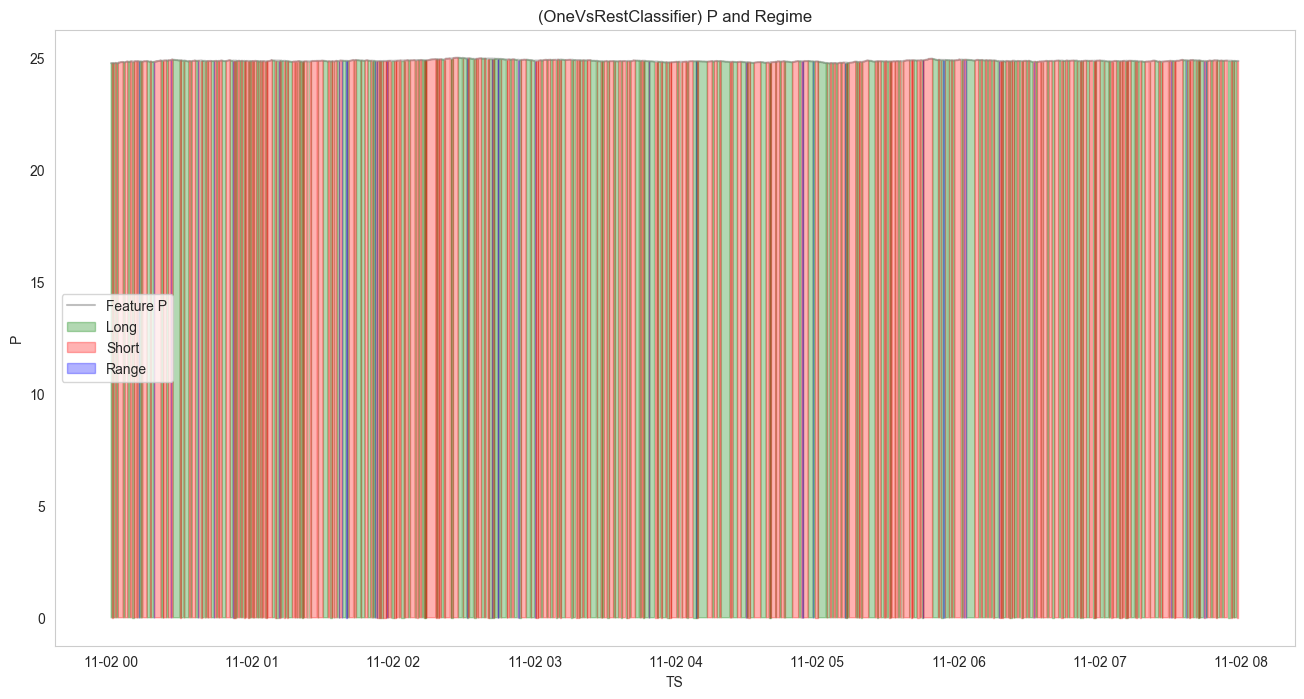

In [1480]:
dpred = df_l.loc[X_normalized.index].copy()
dpred['regime'] = predictions

plot_regime(dpred, model.__class__.__name__)

In [419]:
class HawkesProcess:
    def __init__(self, mu=0.1, alpha=0.5, beta=1.0, l1=1e-4, l2=1e-4, max_history_size=20):
        self.mu = torch.tensor(mu, requires_grad=True, dtype=torch.float32)
        self.alpha = torch.tensor(alpha, requires_grad=True, dtype=torch.float32)
        self.beta = torch.tensor(beta, requires_grad=True, dtype=torch.float32)

        self.l1 = l1
        self.l2 = l2

        self.max_history_size = max_history_size
        self.dtype = torch.float32

        self.reset()

    def reset(self):
        self.event_times = []

    def _exp_kernel(self, time_diff):
        return torch.exp(-self.beta * time_diff)

    def _intensity(self, t):
        if not len(self.event_times):
            return self.mu
        
        event_times = torch.tensor(self.event_times, dtype=self.dtype)

        time_diff = t - event_times

        exp_term = self._exp_kernel(time_diff)

        intensity = self.mu + torch.sum(self.alpha * exp_term)

        intensity = torch.clamp(intensity, min=1e-8, max=1e8)

        return intensity.detach().item()

    def from_events(self, observed_events):
        return torch.tensor([self._intensity(t) for t in observed_events], dtype=self.dtype)
    
    def warmup_with_data(self, warm_up_data):
        self.history = warm_up_data

        if len(self.history) > self.max_history_size:
            self.history = self.history[-self.max_history_size:]


    def simulate(self, T_sim, max_iter=10000, warmup=False):
        if warmup and len(self.event_times) == 0:
            raise ValueError("Event times must be initialized before simulation.")

        t = self.event_times[-1] if len(self.event_times) else 0

        simulated_events = []

        for _ in range(max_iter):
            lambda_t = self._intensity(t)

            upper_bound_intensity = lambda_t * 1.1

            x = torch.distributions.Exponential(rate=1 / upper_bound_intensity).sample().item()
            t += x

            if t >= T_sim:
                break

            if torch.rand(1).item() <= lambda_t / upper_bound_intensity:
                simulated_events.append(t)
                self.history.append(t)

                if len(self.history) > self.max_history_size:
                    self.history.pop(0)

        return torch.tensor(simulated_events, dtype=self.dtype)
    

    def sample(self, n=10):
        sampled_events = []

        t = self.event_times[-1] if len(self.event_times) > 0 else 0
        
        for _ in range(n):
            lambda_t = self._intensity(t)

            upper_bound_intensity = lambda_t * 1.1
            
            x = torch.distributions.Exponential(rate=1 / upper_bound_intensity).sample().item()
            
            t += x
            
            sampled_events.append(t)
            
            if len(self.history) > self.max_history_size:
                    self.history.pop(0)
        return torch.tensor(sampled_events[-n:])

    def fit(self, observed_events, epoch=900, lr=1e-5, clip_value=1.0, batch_size=128):
        observed_events = torch.tensor(observed_events, dtype=self.dtype)
        n_events = len(observed_events)

        optimizer = torch.optim.Adam([self.mu, self.alpha, self.beta], lr=lr)

        for i in range(epoch):
            optimizer.zero_grad()

            batch_loss = torch.tensor(0.0, requires_grad=True, dtype=self.dtype)

            for start in range(0, n_events, batch_size):
                end = min(start + batch_size, n_events)
                batch_events = observed_events[start:end]

                ll = self._ll(batch_events)
                
                mc = self._mc(batch_events)
                
                el = self._el()
                
                batch_loss = batch_loss + (ll - mc) + el

            batch_loss = batch_loss / (n_events / batch_size)

            batch_loss.backward()

            torch.nn.utils.clip_grad_norm_([self.mu, self.alpha, self.beta], clip_value)
            
            optimizer.step()

            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {batch_loss.item()}, mu: {self.mu.item()}, alpha: {self.alpha.item()}, beta: {self.beta.item()}")

    def _ll(self, observed_events):
        previous_times = observed_events.unsqueeze(1) - observed_events.unsqueeze(0)
        time_diffs = torch.tril(previous_times, diagonal=-1)

        intensity_values = self.mu + torch.sum(self.alpha * self._exp_kernel(time_diffs), dim=1)
        intensity_values = torch.clamp(intensity_values, min=1e-10)
        
        ll = torch.sum(torch.log(intensity_values))
        
        return ll
    
    def _mc(self, observed_events, n_samples=1000):
        T = observed_events[-1]
        
        sample_times = torch.rand(n_samples) * T
        
        intensities = self.from_events(sample_times)
        
        integral_term = intensities.mean() * T
        
        return integral_term
    
    def _el(self):
        l1_penalty = self.l1 * (torch.abs(self.mu) + torch.abs(self.alpha) + torch.abs(self.beta))
        l2_penalty = self.l2 * (self.mu ** 2 + self.alpha ** 2 + self.beta ** 2)
        
        return torch.sum(l1_penalty) + torch.sum(l2_penalty)


In [387]:
import torch
import torch.optim as optim

class COEModel:
    def __init__(self, hawkes_model, na=2, nb=1, nh=1, initial_coeff=None, reg_l1=1e-2, reg_l2=1e-3, learning_rate=1e-3, tol=1e-6, patience=250, optimizer_type='Adam'):
        self.hawkes_model = hawkes_model

        self.na = na
        self.nb = nb
        self.nh = nh
        self.coeff = self.initialize_coeff(initial_coeff)
        
        self.reg_l1 = reg_l1
        self.reg_l2 = reg_l2

        self.tol = tol
        self.learning_rate = learning_rate
        self.patience = patience
        self.optimizer_type = optimizer_type
        self.dtype = torch.float32
            
    def initialize_coeff(self, initial_coeff):
        if initial_coeff is not None:
            return torch.tensor(initial_coeff, dtype=self.dtype)
        
        coeff = torch.empty(self.na + self.nb + self.nh, dtype=self.dtype)
        torch.nn.init.xavier_uniform_(coeff.unsqueeze(0))
        
        return coeff

    def fit(self, BI, P, T_sim, epoch=10000):
        self.coeff.requires_grad = True
        optimizer = self._get_optimizer()
        best_loss = float('inf')
        epochs_without_improvement = 0

        for epoch in range(epoch):
            optimizer.zero_grad()

            sim_events = self.hawkes_model.simulate(T_sim)
        
            intensities = self.hawkes_model.from_events(sim_events)

            min_intensity, max_intensity = torch.min(intensities), torch.max(intensities)
            
            E = (intensities - min_intensity) / (max_intensity - min_intensity + 1e-8)

            if len(BI) > len(E):
                BI_window = BI[-len(E):]
            else:
                BI_window = BI

            P_window = P[-len(E):]

            predictions = self._predict(self.coeff, BI_window, E)

            residuals = P_window - predictions
            
            loss = torch.sum(residuals ** 2) + self.reg_l1 * torch.sum(torch.abs(self.coeff)) + self.reg_l2 * torch.sum(self.coeff ** 2)

            loss = loss
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_([self.coeff], max_norm=1.0)
            
            optimizer.step()

            if epoch % 30 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}, Coef: {self.coeff.data}')

            if loss.item() < best_loss:
                best_loss = loss.item()
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= self.patience or loss.item() < self.tol:
                break

    def predict(self, BI, T_sim):
        if self.coeff is None:
            raise ValueError("Model is not fitted yet.")
        
        sim_events = self.hawkes_model.simulate(T_sim)
        intensities = self.hawkes_model.from_events(sim_events)

        min_intensity, max_intensity = torch.min(intensities), torch.max(intensities)
        
        E = (intensities - min_intensity) / (max_intensity - min_intensity + 1e-8)

        if len(BI) > len(E):
            BI_window = BI[-len(E):]
        else:
            BI_window = BI

        return self._predict(self.coeff, BI_window, E)

    def _predict(self, theta, BI, E):
        a_coeff, b_coeff, h_coeff = theta[:self.na], theta[self.na:self.na + self.nb], theta[self.na + self.nb:]  
        
        bi_len = len(BI)

        if bi_len < self.na + self.nb + self.nh:
            raise ValueError("Insufficient data points for specified lags.")
        
        P_pred = torch.zeros(bi_len, dtype=torch.float32)

        for k in range(1, bi_len):
            Plag, BIlag, Elag = self._get_lags(P_pred, BI, E, k)
            
            ar = torch.dot(a_coeff[:len(Plag)], Plag) if Plag.numel() > 0 else 0.0
            ex = torch.dot(b_coeff[:len(BIlag)], BIlag) if BIlag.numel() > 0 else 0.0
            h = torch.dot(h_coeff[:len(Elag)], Elag) if Elag.numel() > 0 else 0.0
            
            P_pred[k] = ar + ex + h

        return P_pred

    def _get_lags(self, P_pred, BI, E, k):
        Plag = P_pred[max(0, k - self.na):k].flip(dims=[0])
        BIlag = BI[max(0, k - self.nb):k].flip(dims=[0])
        Elag = E[max(0, k - self.nh):k].flip(dims=[0])
        
        return Plag, BIlag, Elag

    def _get_optimizer(self):
        if self.optimizer_type == 'SGD':
            return optim.SGD([self.coeff], lr=self.learning_rate)
        elif self.optimizer_type == 'Adam':
            return optim.Adam([self.coeff], lr=self.learning_rate)
        elif self.optimizer_type == 'RMSprop':
            return optim.RMSprop([self.coeff], lr=self.learning_rate)
        else:
            raise ValueError(f"Optimizer {self.optimizer_type} not recognized.")


In [113]:
def train_hawkes(hawkes_model, train_data):
    events = pd.to_datetime(train_data['timestamp'], unit='ms').to_numpy().astype(np.int64) // 10**9

    assert np.all(np.diff(events) >= 0) == True
    
    hawkes_model.fit(events)

def warmup_hawkes(hawkes_model, warmup_data):
    events = pd.to_datetime(warmup_data['timestamp'], unit='ms').to_numpy().astype(np.int64) // 10**9

    assert np.all(np.diff(events) >= 0) == True
    
    hawkes_model.warmup_with_data(events)

def train_coe_model(coe_model, train_data, T_sim, epochs=100):
    P_train, BI_train = train_data['P'].values, train_data['BI'].values

    BI = torch.tensor(BI_train, dtype=torch.float32)
    P = torch.tensor(P_train, dtype=torch.float32)

    coe_model.fit(BI, P, T_sim, epochs)

def eval_coe(coe_model, test_data, T_sim):
    P_test_actual, BI_test = test_data['P'], test_data['BI'].values
    
    events = pd.to_datetime(test_data['timestamp'], unit='ms').to_numpy().astype(np.int64) // 10**9
    
    assert np.all(np.diff(events) >= 0) == True

    BI = torch.tensor(BI_test, dtype=torch.float32)

    P_test_pred = coe_model.predict(BI, T_sim)

    return P_test_pred.detach().numpy(), P_test_actual[-len(P_test_pred):]

In [103]:
T_H = pd.Timedelta(minutes=20)
T_COE_train = pd.Timedelta(minutes=50)
T_warm = pd.Timedelta(minutes=2.5)
delta_T = pd.Timedelta(seconds=5)
T_sim = pd.Timedelta(minutes=2)

X_predict_normalize, X_predict_means, X_predict_stds = normalize(df_l, features)

T_current = pd.to_datetime(X_predict_normalize['timestamp'], unit='ms').max()

test_data_end = T_current
test_data_start = test_data_end - T_sim
print(f"Test Period: {test_data_start} to {test_data_end}")

coe_train_end = test_data_start
coe_train_start = coe_train_end - T_COE_train
print(f"COE Training Period: {coe_train_start} to {coe_train_end}")

warm_up_end = coe_train_start
warm_up_start = warm_up_end - T_warm
print(f"Warm-up Period: {warm_up_start} to {warm_up_end}")

hawkes_train_end = warm_up_start
hawkes_train_start = hawkes_train_end - T_H
print(f"Training Period for Hawkes: {hawkes_train_start} to {hawkes_train_end}")

train_data = X_predict_normalize[(X_predict_normalize['timestamp'] >= hawkes_train_start) & (X_predict_normalize['timestamp'] < hawkes_train_end)]
warm_up_data = X_predict_normalize[(X_predict_normalize['timestamp'] >= warm_up_start) & (X_predict_normalize['timestamp'] < warm_up_end)]
train_coe_data = X_predict_normalize[(X_predict_normalize['timestamp'] >= coe_train_start) & (X_predict_normalize['timestamp'] < coe_train_end)]
test_data = X_predict_normalize[(X_predict_normalize['timestamp'] >= test_data_start) & (X_predict_normalize['timestamp'] < test_data_end)]

print(f"Train Hawkes : {train_data.shape}")
print(f"Warm Up Hawkes : {warm_up_data.shape}")
print(f"Train COE : {train_coe_data.shape}")
print(f"Test COE : {test_data.shape}")

Test Period: 2024-11-02 07:56:48.347000 to 2024-11-02 07:58:48.347000
COE Training Period: 2024-11-02 07:06:48.347000 to 2024-11-02 07:56:48.347000
Warm-up Period: 2024-11-02 07:04:18.347000 to 2024-11-02 07:06:48.347000
Training Period for Hawkes: 2024-11-02 06:44:18.347000 to 2024-11-02 07:04:18.347000
Train Hawkes : (144, 10)
Warm Up Hawkes : (18, 10)
Train COE : (360, 10)
Test COE : (14, 10)


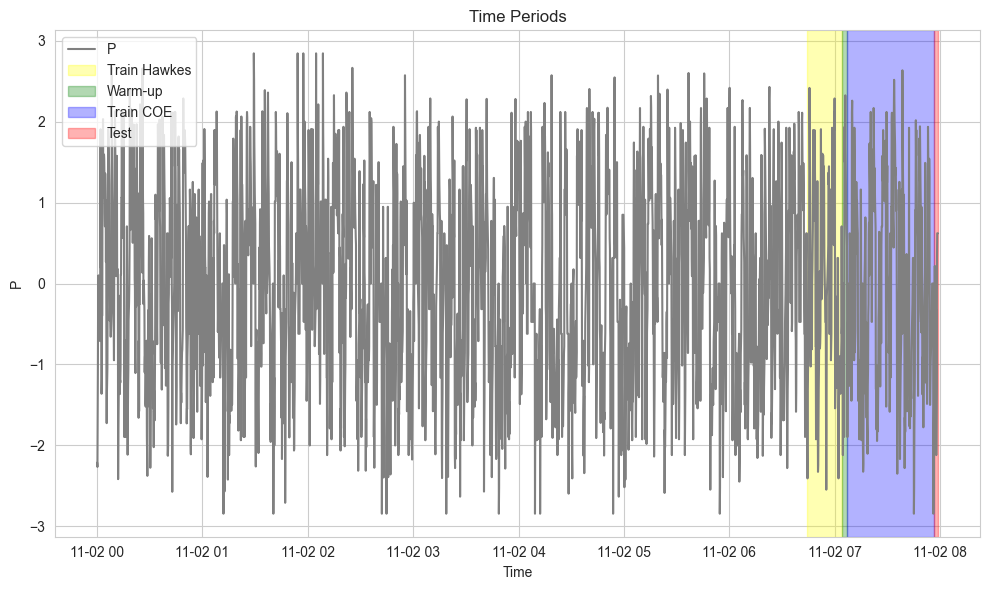

In [109]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))

plt.plot(pd.to_datetime(X_predict_normalize['timestamp'], unit='ms'), X_predict_normalize['P'], label="P", color='gray')


plt.axvspan(hawkes_train_start, hawkes_train_end, color='yellow', alpha=0.3, label="Train Hawkes")
plt.axvspan(warm_up_start, warm_up_end, color='green', alpha=0.3, label="Warm-up")
plt.axvspan(coe_train_start, coe_train_end, color='blue', alpha=0.3, label="Train COE")
plt.axvspan(test_data_start, test_data_end, color='red', alpha=0.3, label="Test")

plt.xlabel("Time")
plt.ylabel("P")
plt.title("Time Periods")
plt.legend(loc="upper left")


plt.tight_layout()
plt.show()

In [192]:
hawkes_model = HawkesProcess()

In [193]:
train_hawkes(hawkes_model, train_data)

NameError: name 'train_hawkes' is not defined

In [117]:
warmup_hawkes(hawkes_model, warm_up_data)

In [67]:
coeff = None
optimizer = 'Adam'

coe_model = COEModel(hawkes_model, na=5, nb=2, nh=2, initial_coeff=coeff, optimizer_type=optimizer)


In [68]:
train_coe_model(coe_model, train_coe_data, T_sim.total_seconds())
coe_model.coeff

Epoch 0, Loss: 1591.2060546875, Coef: tensor([ 0.5198,  0.3642, -0.1053, -0.0845, -0.5336,  0.3220,  0.0446, -0.6433,
         0.2636])
Epoch 30, Loss: 306.5362243652344, Coef: tensor([ 0.4912,  0.3414, -0.0984, -0.0596, -0.5052,  0.2939,  0.0176, -0.6542,
         0.2535])
Epoch 60, Loss: 200.61053466796875, Coef: tensor([ 0.4640,  0.3219, -0.0837, -0.0326, -0.4763,  0.2616, -0.0131, -0.6477,
         0.2573])
Epoch 90, Loss: 152.20472717285156, Coef: tensor([ 0.4370,  0.2949, -0.0858, -0.0177, -0.4561,  0.2182, -0.0543, -0.6105,
         0.2908])


tensor([ 0.4298,  0.2858, -0.0915, -0.0176, -0.4533,  0.2050, -0.0665, -0.5965,
         0.3043], requires_grad=True)

In [70]:
predict, actual = eval_coe(coe_model, test_data, T_sim)

In [37]:
def plot_predicted_vs_actual(predicted, actual):
    event_index = np.arange(len(actual))

    plt.figure(figsize=(12, 6))
    plt.plot(event_index, predicted, label='Predicted', color='orange', linestyle='--', alpha=0.7)
    plt.plot(event_index, actual, label='Actual', color='blue', alpha=0.7)

    plt.title('Predicted v Actual Values')
    plt.xlabel('Event')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actual, predict)
mse = mean_squared_error(actual, predict)
rmse = np.sqrt(mse)
r2 = r2_score(actual, predict)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 0.7414997036390049
MSE: 0.7897374371381586
RMSE: 0.8886717263073911
R²: 0.18893924271535845


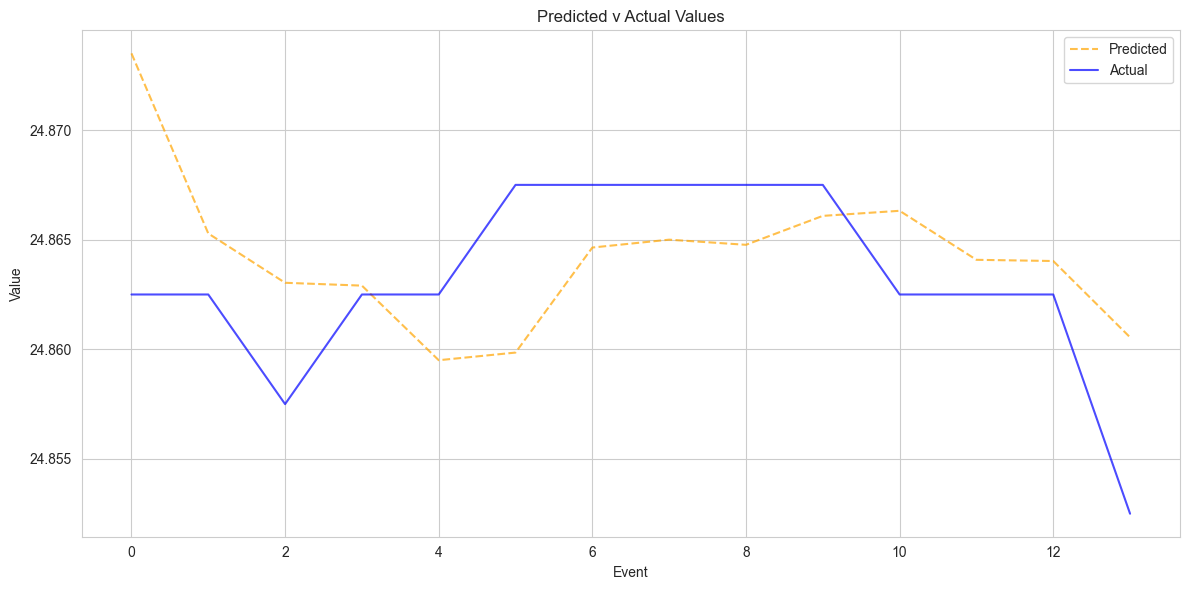

In [72]:
means_P = X_predict_means['P'].reindex(actual.index)
stds_P = X_predict_stds['P'].reindex(actual.index)

predict_price = predict * (stds_P + EPS) + means_P
actual_price = actual * (stds_P + EPS) + means_P

plot_predicted_vs_actual(predict_price, actual_price)

In [85]:
def create_prob_edge_index(intencity, sigmoid_scaling=0.5):
    n = len(intencity)

    intencity_tensor = intencity if isinstance(intencity, torch.Tensor) else torch.tensor(intencity, dtype=torch.float32)

    mask = torch.tril(torch.ones((n, n), dtype=torch.bool), diagonal=-1)
    
    intensities = torch.zeros((n, n), dtype=torch.float32)
    
    for i in range(n):
        intensities[i][mask[i]] = intencity_tensor[i]

    min_intensity, max_intensity = intensities.min(), intensities.max()
    intensities = (intensities - min_intensity) / (max_intensity - min_intensity + EPS)

    probabilities = torch.sigmoid(sigmoid_scaling * intensities)
    
    random_values = torch.rand((n, n))
    selected_edges = (random_values < probabilities) & mask
    
    edge_list = selected_edges.nonzero(as_tuple=False).t()
    edge_weights = probabilities[selected_edges]
    
    assert edge_list.shape[1] == edge_weights.shape[0], "Mismatch between edge_list and edge_weights."
    
    return edge_list, edge_weights

In [58]:
T_sim = pd.Timedelta(seconds=15)
T_H = pd.Timedelta(minutes=180)

h_event_times = pd.to_datetime(timestamps.to_numpy().astype(np.int64) // 10**9, unit="s")

T_current = h_event_times.max()
hw_start = T_current - T_H

hw_train = h_event_times[h_event_times > hw_start].values.astype(np.int64)

assert np.all(np.diff(hw_train) >= 0) == True

hw_train.shape

(1296,)

In [89]:
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

BATCH_SIZE = 32
TEST_RATIO = 0.2


X_train, X_test, y_train, y_test, I_test, I_train = train_test_split(
    X_t, y_t, I_t, test_size=TEST_RATIO, random_state=seed, stratify=y_t
)

train_data_list, test_data_list = [], []

def create_graph_samples(X, y, I, batch_size=BATCH_SIZE):
    data_list = []

    for i in range(0, len(X), batch_size):
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        I_batch = I[i:i + batch_size]

        edge_index, edge_attr_weights = create_prob_edge_index(I_batch)
        
        num_edges = edge_index.shape[1]
        edge_attr = edge_attr_weights[:num_edges].view(-1)

        PS = X_batch[:, features.index('PS')]
        VI = X_batch[:, features.index('VI')]
        BI = X_batch[:, features.index('BI')]
        
        PS_edges = PS[edge_index[0]]
        VI_edges = VI[edge_index[0]]
        BI_edges = BI[edge_index[0]]

        edge_attr = torch.stack((edge_attr, PS_edges, VI_edges, BI_edges), dim=1)

        data = Data(x=X_batch, edge_index=edge_index, edge_attr=edge_attr, y=y_batch)
        data_list.append(data)
    
    return data_list


train_data_list = create_graph_samples(X_train, y_train, I_test)
test_data_list = create_graph_samples(X_test, y_test, I_train)

train_dataloader = DataLoader(train_data_list, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data_list, batch_size=1)

In [91]:
batch = next(iter(train_dataloader))

print("Node features (X):", batch.x.shape)
print("Edge index:", batch.edge_index.shape)
print("Edge attr:", batch.edge_attr.shape)
print("y:", batch.y.shape)
print("batch:", batch.batch)

unique_nodes = batch.edge_index.unique()

print("Unique node indices:", unique_nodes)
print("Max node index:", unique_nodes.max().item())

Node features (X): torch.Size([32, 6])
Edge index: torch.Size([2, 260])
Edge attr: torch.Size([260, 4])
y: torch.Size([32])
batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Unique node indices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
Max node index: 31


In [92]:
L = 6

def create_pairs(data_list, L, batch_size):
    size_map = {}

    for graph in data_list:
        size = graph.num_nodes
        
        if size not in size_map:
            size_map[size] = []
        
        size_map[size].append(graph)
    
    fixed_size_pairs = []

    for graphs in size_map.values():
        if len(graphs) >= L:
            for i in range(0, len(graphs) - L, batch_size):
                if i + L < len(graphs):
                    for j in range(batch_size):
                        if i + j + L < len(graphs):
                            fixed_size_pairs.append((graphs[i + j], graphs[i + j + L]))

    return fixed_size_pairs

train_pairs = create_pairs(train_data_list, L, BATCH_SIZE)
test_pairs = create_pairs(test_data_list, L, BATCH_SIZE)

train_pairs_dataloader = DataLoader(train_pairs, batch_size=1, shuffle=True)
test_pairs_dataloader = DataLoader(test_pairs, batch_size=1)

In [93]:
next(iter(train_pairs_dataloader))

[DataBatch(x=[32, 6], edge_index=[2, 247], edge_attr=[247, 4], y=[32], batch=[32], ptr=[2]),
 DataBatch(x=[32, 6], edge_index=[2, 257], edge_attr=[257, 4], y=[32], batch=[32], ptr=[2])]

In [94]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)

        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        return F_loss

In [95]:
class GCPDLoss(nn.Module):
    def __init__(self, margin=1.0, positive_weight=1.0, negative_weight=1.0, mse_weight=0.5, l2_reg_weight=0.01, reduction='mean'):
        super(GCPDLoss, self).__init__()
        self.margin = margin
        self.positive_weight = positive_weight
        self.negative_weight = negative_weight
        self.reduction = reduction
        self.l2_reg_weight = l2_reg_weight
        self.mse_weight = mse_weight
        self.mse_loss = nn.MSELoss(reduction='none')

    def forward(self, emb1, emb2, target):
        distance = nn.functional.pairwise_distance(emb1, emb2, p=2)

        pos_loss = self.positive_weight * target * torch.pow(distance, 2)
        neg_loss = self.negative_weight * (1 - target) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)

        loss = pos_loss + neg_loss

        loss += self.l2_reg_weight * (torch.norm(emb1 - emb2, p=2) ** 2)
        loss += self.mse_weight * self.mse_loss(emb1, emb2).mean(dim=1)
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [96]:
class GATEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, num_layers, dropout=0.2, activation=F.relu):
        super(GATEncoder, self).__init__()
        self.num_layers = num_layers
        self.activation = activation

        self.convs = nn.ModuleList()
        
        self.convs.append(gnn.GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout))
        
        for _ in range(1, num_layers - 1):
            self.convs.append(gnn.GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, dropout=dropout, residual=True))
        
        self.convs.append(gnn.GATConv(hidden_dim * num_heads, output_dim, heads=num_heads, dropout=dropout, concat=False))

        self.norms = nn.ModuleList([gnn.GraphNorm(hidden_dim * num_heads) for _ in range(num_layers - 1)])

    def forward(self, x, edge_index, edge_attr):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index, edge_attr)
            x = self.activation(x)
            x = self.norms[i](x)
            x = F.dropout(x, p=0.2, training=self.training)

        x = self.convs[-1](x, edge_index, edge_attr)

        return x
    
class PE(nn.Module):
    def __init__(self, dim, max_len):
        super(PE, self).__init__()
        
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
        
        pe = torch.zeros(max_len, dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

class TopKModule(nn.Module):
    def __init__(self, k, embed_dim, num_heads, max_len):
        super(TopKModule, self).__init__()
        self.k = k
        self.pe = PE(embed_dim, max_len=max_len)
        self.self_att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)

    def forward(self, emb1, emb2):
        dist = torch.cdist(emb1, emb2, p=2)
        
        top_dist, _ = torch.topk(dist, self.k, dim=1, largest=True)
        
        top_dist = self.pe(top_dist.unsqueeze(1))

        x_att, _ = self.self_att(top_dist, top_dist, top_dist)
        
        x = torch.mean(x_att, dim=1)
        
        return x
    
class SimilarityModule(nn.Module):
    def __init__(self, output_dim, num_heads=5, k=10, max_len=500):
        super(SimilarityModule, self).__init__()
        self.top_k = TopKModule(k=k, embed_dim=k, num_heads=num_heads, max_len=max_len)

        self.fc1 = nn.Linear(k, output_dim)
        self.ln1 = nn.BatchNorm1d(output_dim)
        
        self.fc2 = nn.Linear(output_dim, output_dim // 2)
        self.ln2 = nn.BatchNorm1d(output_dim // 2)
        
        self.output_fc = nn.Linear(output_dim // 2, 1)

    def forward(self, emb1, emb2):
        x = self.top_k(emb1, emb2)

        x = F.gelu(self.ln1(self.fc1(x)))
        x = F.gelu(self.ln2(self.fc2(x)))
        x = self.output_fc(x)

        out = torch.sum(x, dim=1, keepdim=True)

        return out
    
class GCPD(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, num_layers, top_k):
        super(GCPD, self).__init__()
        self.encoder = GATEncoder(input_dim, hidden_dim, output_dim, num_heads, num_layers)
        self.similarity_module = SimilarityModule(output_dim, top_k)

    def forward(self, g1, g2):
        emb1 = self.encoder(g1[0], g1[1], g1[2])
        emb2 = self.encoder(g2[0], g2[1], g2[2])

        return self.similarity_module(emb1, emb2)

In [97]:
import torch.optim as optim
from notebooks.train import CheckPoint, EarlyStop, SnapshotManager

n_snapshots = 3
patience = 16
snapshot_interval = 5
epoch = 20

INPUT = X_train.shape[1]
HIDDEN = 64
NUM_HEADS = 8
NUM_LAYERS = 4
OUTPUT = 16
TOP_K = 10
LR = 0.0001

model_gcpd = GCPD(INPUT, HIDDEN, OUTPUT, NUM_HEADS, NUM_LAYERS, TOP_K)
optimizer = optim.Adam(model_gcpd.parameters(), lr=LR)
criterion = GCPDLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)

snapshot_manager = SnapshotManager(model_gcpd, n_snapshots=n_snapshots)
early_stop = EarlyStop(patience=patience)
checkpoint = CheckPoint(
    snapshot_manager=snapshot_manager, snapshot_interval=snapshot_interval
)
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [98]:
import gc
from contextlib import contextmanager

@contextmanager
def autocleanup(*tensors):
    yield
    for tensor in tensors:
        del tensor
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

In [99]:
from notebooks.train import Trainer

class GCPDTrainer(Trainer):
    def __init__(self, *args, acc_steps=4, **kwargs):
        super().__init__(*args, **kwargs)
        self.acc_steps = acc_steps

    def train_epoch(self):
        self.model.train()
        running_train_loss = 0.0
        num_batches = len(self.train_dataloader)
        acc_loss = 0.0

        for batch_idx, batch in enumerate(self.train_dataloader):
            g1 = (batch[0].x.to(device), batch[0].edge_index.to(device), batch[0].edge_attr.to(device))
            g2 = (batch[1].x.to(device), batch[1].edge_index.to(device), batch[1].edge_attr.to(device))
            
            with autocleanup(g1, g2):
                emb1 = self.model.encoder(g1[0], g1[1], g1[2])
                emb2 = self.model.encoder(g2[0], g2[1], g2[2])

                output = self.model.similarity_module(emb1, emb2)
                scores = torch.sigmoid(output)
                
                loss = self.calc_loss(emb1, emb2, self.criterion, scores)

                acc_loss += loss.item()

                loss.backward()

                if (batch_idx + 1) % self.acc_steps == 0 or (batch_idx + 1) == num_batches:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    running_train_loss += acc_loss
                    acc_loss = 0.0

                del batch, output, loss, emb1, emb2

        avg_train_loss = running_train_loss / max(1, (num_batches + self.acc_steps - 1) // self.acc_steps)

        return avg_train_loss

    def valid_epoch(self):
        return 0.0
    
    @staticmethod
    def calc_loss(emb1, emb2, criterion, scores):
        pseudo_labels = (scores > 0.5).float()

        targets = pseudo_labels.view(-1) 
        
        loss = criterion(emb1, emb2, targets)

        return loss
    

In [100]:
trainer = GCPDTrainer(
    model_gcpd,
    train_pairs_dataloader,
    test_pairs_dataloader,
    optimizer,
    scheduler,
    criterion,
    early_stop,
    checkpoint,
    device=device
)


No snapshots found, starting from scratch.


In [101]:
trainer.train(epoch)

Start training with epochs 20


/Users/siarheimelnik/Projects/quant-prod/.venv/lib/python3.12/site-packages/torch_geometric/utils/_scatter.py:102: UserWarning: The operator 'aten::scatter_reduce.two_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return src.new_zeros(size).scatter_reduce_(


Epoch 1/20, Train_Loss: 14.3425, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GCPD_epoch_1_improved.pth
Epoch 2/20, Train_Loss: 11.5696, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GCPD_epoch_2_improved.pth
Epoch 3/20, Train_Loss: 10.3821, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GCPD_epoch_3_improved.pth
Epoch 4/20, Train_Loss: 9.9521, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GCPD_epoch_4_improved.pth
Removed old improved snapshot: snapshots/GCPD_epoch_1_improved.pth
Removed old improved snapshot: snapshots/GCPD_epoch_2_improved.pth
Removed old improved snapshot: snapshots/GCPD_epoch_3_improved.pth
Epoch 5/20, Train_Loss: 8.8314, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GCPD_epoch_5_improved.pth
Saved periodic snapshot: snapshots/GCPD_epoch_5_periodic.pth
Epoch 6/20, Train_Loss: 8.4434, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GCPD_epoch_6_improved.pth
Removed old improved snapshot: snapshots/GCPD_epoch_4_improved.pth
Removed 

In [103]:
def extract_embeddings_and_scores(dataloader, model, device):
    model.eval()
    all_emb1 = []
    all_emb2 = []
    all_scores = []

    with torch.no_grad():
        for batch in dataloader:
            g1 = (batch[0].x.to(device), batch[0].edge_index.to(device), batch[0].edge_attr.to(device))
            g2 = (batch[1].x.to(device), batch[1].edge_index.to(device), batch[1].edge_attr.to(device))

            emb1 = model.encoder(g1[0], g1[1], g1[2])
            emb2 = model.encoder(g2[0], g2[1], g2[2])

            output = model.similarity_module(emb1, emb2)

            scores = torch.sigmoid(output)

            all_emb1.append(emb1.cpu().numpy())
            all_emb2.append(emb2.cpu().numpy())
            all_scores.append(scores.cpu().numpy())

    all_emb1 = np.concatenate(all_emb1)
    all_emb2 = np.concatenate(all_emb2)
    all_scores = np.concatenate(all_scores)

    return all_emb1, all_emb2, all_scores

Loaded snapshot: snapshots/GCPD_epoch_17_improved.pth
Imbalance ratio: 0.0


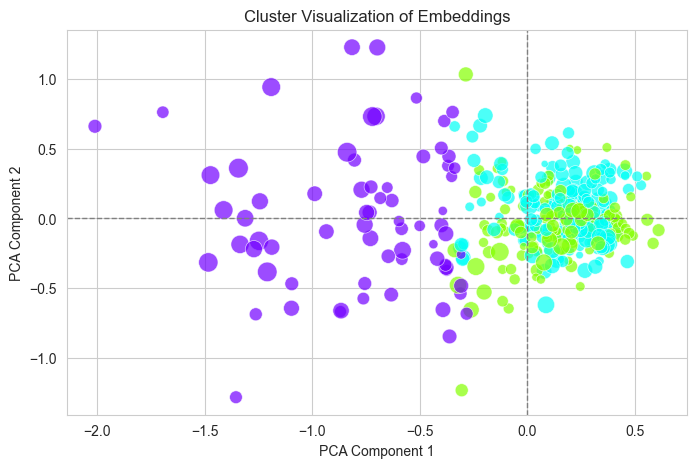

In [104]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

model_gcpd_inf = GCPD(INPUT, HIDDEN, OUTPUT, NUM_HEADS, NUM_LAYERS, TOP_K)
model_gcpd_inf.to(device)

snapshot_manager = SnapshotManager(model_gcpd_inf)
snapshot_manager.load_latest()

emb1, emb2, scores = extract_embeddings_and_scores(test_pairs_dataloader, model_gcpd_inf, device)

positive_scores = scores[scores > 0.5].sum()
negative_scores = scores[scores <= 0.5].sum()
imb_ratio = positive_scores / (negative_scores + EPS)

print(f"Imbalance ratio: {imb_ratio}")

combo = np.concatenate((emb1, emb2), axis=1)

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=seed)
kmeans.fit(combo)

cluster_labels = kmeans.labels_

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combo)

df_score = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])
df_score['Cluster'] = cluster_labels
df_score['Score'] = np.concatenate((scores[scores > 0.5], scores[scores <= 0.5]), axis=0)

plt.figure(figsize=(8, 5))

palette = sns.color_palette("hsv", num_clusters)

sns.scatterplot(data=df_score, x='Component 1', y='Component 2', hue='Cluster', size='Score', sizes=(20, 200),
                palette=palette, alpha=0.7, legend=False)

plt.title('Cluster Visualization of Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.axhline(0, color='gray', lw=1, ls='--')
plt.axvline(0, color='gray', lw=1, ls='--')
plt.grid(True)

plt.show()


In [3665]:
ONE_MINUTE = 60
MULTI = 1
K = 8

wfe = fe(warm_up(symbol[0], DOM, ONE_MINUTE * MULTI), K)

X_inf, X_means_inf, X_stds_inf = normalize(wfe, features)
events = pd.to_datetime(wfe.loc[X_inf.index]['timestamp'], unit='ms').to_numpy().astype(np.int64) // 10**9

In [3673]:
hawkes_inf_model = HawkesProcess(reg_mu=1e-3, reg_alpha=1e-2, reg_beta=1e-2)

In [3674]:
hawkes_inf_model.fit(events, epoch=3600, lr=1e-4)

print(f"Mu: {hawkes_inf_model.mu}, Alpha: {hawkes_inf_model.alpha}, Beta: {hawkes_inf_model.beta}")

Iteration 0, Loss: 5.2532124519348145, mu: 0.10000099986791611, alpha: 0.5000010132789612, beta: 0.9999989867210388
Iteration 100, Loss: 5.24444580078125, mu: 0.10010083764791489, alpha: 0.5001023411750793, beta: 0.9998976588249207
Iteration 200, Loss: 5.235701084136963, mu: 0.10020067542791367, alpha: 0.5002036690711975, beta: 0.9997963309288025
Iteration 300, Loss: 5.226960182189941, mu: 0.10030051320791245, alpha: 0.5003049969673157, beta: 0.9996950030326843
Iteration 400, Loss: 5.218227863311768, mu: 0.10040035098791122, alpha: 0.5004063248634338, beta: 0.9995936751365662
Iteration 500, Loss: 5.2095046043396, mu: 0.10050018876791, alpha: 0.500507652759552, beta: 0.999492347240448
Iteration 600, Loss: 5.200795650482178, mu: 0.10060002654790878, alpha: 0.5006089806556702, beta: 0.9993910193443298
Iteration 700, Loss: 5.192091464996338, mu: 0.10069986432790756, alpha: 0.5007103085517883, beta: 0.9992896914482117
Iteration 800, Loss: 5.183398723602295, mu: 0.10079970210790634, alpha: 0

In [1631]:
import torch
from torch_geometric.nn import GATConv, SAGPooling, global_max_pool
from torch import nn
import torch.nn.functional as F

class JumpDiffusionLayer(nn.Module):
    def __init__(self, out_channels, jump_intensity, jump_scale, volatility=0.1, alpha=0.1, beta=0.85, asymmetry=0.1, learnable=True):
        super(JumpDiffusionLayer, self).__init__()
        self.jump_intensity_up = nn.Parameter(torch.tensor(jump_intensity), requires_grad=learnable)
        self.jump_intensity_down = nn.Parameter(torch.tensor(jump_intensity * asymmetry), requires_grad=learnable)
        self.jump_scale = nn.Parameter(torch.tensor(jump_scale), requires_grad=learnable)
        self.volatility = nn.Parameter(torch.tensor(volatility), requires_grad=learnable)
        
        self.alpha = alpha
        self.beta = beta
        self.eps = np.finfo(float).eps
                
        self.layer_norm = nn.LayerNorm(out_channels)

    def forward(self, x):
        if x.ndim != 2:
            raise ValueError("Input x must be a 2D tensor with shape [batch_size, features]")

        returns = (x - x.roll(shifts=1, dims=0)) / (x.roll(shifts=1, dims=0) + self.eps)
        returns[0] = 0
        squared_returns = returns ** 2

        current_volatility = torch.sqrt(self.alpha * squared_returns.mean(dim=0) + self.beta * (self.volatility ** 2))

        adj_jump_intensity_up = torch.clamp(self.jump_intensity_up * current_volatility / self.volatility, min=0)
        adj_jump_intensity_down = torch.clamp(self.jump_intensity_down * current_volatility / self.volatility, min=0)

        jumps_up = torch.poisson(adj_jump_intensity_up) * torch.normal(mean=0, std=self.jump_scale).clamp(-3, 3)
        jumps_down = torch.poisson(adj_jump_intensity_down) * torch.normal(mean=0, std=self.jump_scale).clamp(-3, 3)
        x_jump = x.clone()
        x_jump += F.elu(jumps_up) * adj_jump_intensity_up - F.elu(jumps_down) * (1 - adj_jump_intensity_down)
       
        return self.layer_norm(x_jump)

class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(CrossAttentionLayer, self).__init__()
        self.cross_attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.linear = nn.Linear(embed_dim, embed_dim)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key, value):
        attn_output, _ = self.cross_attention(query, key, value)
        query = query + attn_output
        query = self.layer_norm1(query)

        complex_output = self.linear(query)
        complex_output = F.gelu(complex_output)
        query = query + complex_output

        return self.layer_norm2(query)
    
class FusionLayer(nn.Module):
    def __init__(self, in_channels1, in_channels2, out_channels, attention_heads=4, dropout=0.1):
        super(FusionLayer, self).__init__()
        self.fc1_1d = nn.Linear(in_channels1, out_channels)
        self.fc2_2d = nn.Linear(in_channels2, out_channels)

        self.self_attention_1d = nn.MultiheadAttention(embed_dim=out_channels, num_heads=attention_heads, dropout=dropout)
        self.self_attention_2d = nn.MultiheadAttention(embed_dim=out_channels, num_heads=attention_heads, dropout=dropout)
        self.cross_attention = CrossAttentionLayer(embed_dim=out_channels, num_heads=attention_heads, dropout=dropout)
        
        self.fc_fuse1 = nn.Linear(out_channels * 2, out_channels)
        self.fc_fuse2 = nn.Linear(out_channels, out_channels)
        self.layer_norm = nn.LayerNorm(out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x1d, x2d):
        x1d_transformed = F.relu(self.fc1_1d(x1d.view(x1d.size(0), -1)))
        x2d_transformed = F.relu(self.fc2_2d(x2d.view(x2d.size(0), -1)))

        x1d_self_attended, _ = self.self_attention_1d(x1d_transformed.unsqueeze(0), x1d_transformed.unsqueeze(0), x1d_transformed.unsqueeze(0))
        x2d_self_attended, _ = self.self_attention_2d(x2d_transformed.unsqueeze(0), x2d_transformed.unsqueeze(0), x2d_transformed.unsqueeze(0))

        fused = self.cross_attention(x1d_self_attended, x2d_self_attended, x2d_self_attended)
        fused = torch.cat((fused.squeeze(0), x1d_transformed), dim=1)
        fused = self.dropout(self.layer_norm(F.relu(self.fc_fuse1(fused))))
        fused = self.fc_fuse2(fused)

        return fused
    
class GNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, heads=4, dropout=0.1, ratio=0.5):
        super(GNNLayer, self).__init__()
        self.gat_conv1 = GATConv(in_channels, out_channels, heads=heads, dropout=dropout)
        self.gat_conv2 = GATConv(out_channels * heads, out_channels, heads=heads, dropout=dropout)

        self.pool = SAGPooling(in_channels=out_channels * heads, ratio=ratio)
        self.fc1 = nn.Linear(out_channels * heads, out_channels)
        self.layer_norm = nn.LayerNorm(out_channels)

    def forward(self, x, edge_index, edge_attr):
        x_gat = self.gat_conv1(x, edge_index, edge_attr)
        x_gat = self.gat_conv2(x_gat, edge_index, edge_attr)

        x_pooled, edge_index, edge_attr, _, _, _ = self.pool(x_gat, edge_index, edge_attr)
        x_pooled = global_max_pool(x_pooled, batch=None)

        x_fc = F.relu(self.fc1(x_pooled))
        x_fc = self.layer_norm(x_fc)

        return x_fc

class ORCA(nn.Module):
    def __init__(self, in_channels, conv_out_channels, gat_heads=4, gat_dropout=0.1, classes=3, jump_intensity=0.1, jump_scale=0.05):
        super(ORCA, self).__init__()

        self.conv_block1_2d = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=conv_out_channels, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),

            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),
        )

        self.residual1 = nn.Conv2d(in_channels, conv_out_channels, kernel_size=1)

        self.conv_block2_2d = nn.Sequential(
            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(1, 2), stride=(1, 1), padding=(0, 1)),
            nn.Tanh(),
            nn.BatchNorm2d(conv_out_channels),

            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(2, 1), stride=(1, 1), padding=(1, 0)),
            nn.Tanh(),
            nn.BatchNorm2d(conv_out_channels),
        )

        self.conv_block3_2d = nn.Sequential(
            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(2, 2), stride=(2, 2), padding=(0, 0)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),

            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),
        )

        self.residual3 = nn.Conv2d(conv_out_channels, conv_out_channels, kernel_size=1, stride=2)

        self.conv_block1_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels // 4, kernel_size=3, padding=1),
            nn.Mish(),
            nn.BatchNorm1d(conv_out_channels // 4),
        )
        self.conv_block2_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels // 4, kernel_size=5, padding=2),
            nn.SELU(),
            nn.BatchNorm1d(conv_out_channels // 4),
        )
        self.conv_block3_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels // 4, kernel_size=7, padding=3),
            nn.SiLU(),
            nn.BatchNorm1d(conv_out_channels // 4),
        )
        self.conv_block4_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels // 4, kernel_size=9, padding=4),
            nn.GELU(),
            nn.BatchNorm1d(conv_out_channels // 4),
        )
        
        self.fusion_layer = FusionLayer(conv_out_channels, conv_out_channels, conv_out_channels)
        self.jump_diffusion = JumpDiffusionLayer(conv_out_channels, jump_intensity, jump_scale)

        self.gnn_layer = GNNLayer(in_channels, conv_out_channels, gat_heads, gat_dropout)

        self.fd1 = nn.Dropout(0.15)
        self.fc1 = nn.Linear(conv_out_channels, classes)

        self.apply(self._init_weights)

    def forward(self, x, edge_index, edge_attr):
        x1 = x.unsqueeze(1).transpose(1, 2)
        x2 = x1.unsqueeze(2)

        residual1 = self.residual1(x2)
        x2d = self.conv_block1_2d(x2) + residual1

        residual2 = x2d
        x2d = self.conv_block2_2d(x2d) + residual2

        residual3 = self.residual3(x2d)
        x2d = self.conv_block3_2d(x2d) + residual3

        x1d1 = self.conv_block1_1d(x1)
        x1d2 = self.conv_block2_1d(x1)
        x1d3 = self.conv_block3_1d(x1)
        x1d4 = self.conv_block4_1d(x1)

        x1d = torch.cat((x1d1, x1d2, x1d3, x1d4), dim=1)

        x_fused = self.fusion_layer(x1d, x2d)
        # x_jump = self.jump_diffusion(x_fused)
      
        x_gnn = self.gnn_layer(x, edge_index, edge_attr)

        x_combined = x_fused + x_gnn

        x_fc = self.fd1(x_combined)
        x_fc = x_fc.view(x_fc.size(0), -1)
        x_fc = F.relu(self.fc1(x_fc))
        
        return x_fc
    
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            nn.init.xavier_normal_(m.weight)

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.LayerNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)


In [833]:
import torch.optim as optim
from notebooks.train import CheckPoint, EarlyStop, SnapshotManager

n_snapshots = 3
patience = 16
snapshot_interval = 5
epoch = 50

modelv1 = ORCA(in_channels=X_train.shape[1], conv_out_channels=64, gat_heads=8)
optimizer = optim.AdamW(modelv1.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
criterion = FocalLoss()

snapshot_manager = SnapshotManager(modelv1, n_snapshots=n_snapshots)
early_stop = EarlyStop(patience=patience)
checkpoint = CheckPoint(
    snapshot_manager=snapshot_manager, snapshot_interval=snapshot_interval
)

In [859]:
import gc
from notebooks.train import Trainer

class ORCATrainer(Trainer):
    def __init__(self, *args, acc_steps=4, l1_lambda=0.001, **kwargs):
        super().__init__(*args, **kwargs)
        self.acc_steps = acc_steps
        self.l1_lambda = l1_lambda

    def compute_l1_loss(self):
        l1_loss = 0.0

        for param in self.model.parameters():
            l1_loss += torch.sum(torch.abs(param))
        
        return self.l1_lambda * l1_loss
    
    def train_epoch(self):
        self.model.train()
        running_train_loss = 0.0
        num_batches = len(self.train_dataloader)
        acc_loss = 0.0

        for batch_idx, batch in enumerate(self.train_dataloader):
            output = self.model(batch.x.to(self.device), batch.edge_index.to(self.device), batch.edge_attr.to(self.device))

            loss = self.criterion(output, batch.y.to(self.device)) / self.acc_steps
            l1_loss = self.compute_l1_loss()
            
            total_loss = loss + l1_loss

            acc_loss += loss.item()

            total_loss.backward()

            if (batch_idx + 1) % self.acc_steps == 0 or (batch_idx + 1) == num_batches:
                self.optimizer.step()
                self.optimizer.zero_grad()
                running_train_loss += acc_loss
                acc_loss = 0.0

            del batch, output, loss

            if (batch_idx + 1) % (self.acc_steps * 5) == 0:
                if torch.backends.mps.is_available():
                    torch.mps.empty_cache()
                elif torch.cuda.is_available():
                    torch.cuda.empty_cache()

                gc.collect()

        if acc_loss > 0:
            running_train_loss += acc_loss

        num_updates = (num_batches + self.acc_steps - 1) // self.acc_steps
        avg_train_loss = running_train_loss / num_updates if num_updates > 0 else float("inf")

        return avg_train_loss

    def valid_epoch(self):
        self.model.eval()
        running_val_loss = 0.0
        num_batches = len(self.test_dataloader)
        acc_loss = 0.0

        with torch.no_grad():
            for batch_idx, batch in enumerate(self.test_dataloader):
                output = self.model(batch.x.to(self.device), batch.edge_index.to(self.device), batch.edge_attr)
                loss = self.criterion(output, batch.y.to(self.device)) / self.acc_steps
                acc_loss += loss.item()

                if (batch_idx + 1) % self.acc_steps == 0 or (batch_idx + 1) == num_batches:
                    running_val_loss += acc_loss
                    acc_loss = 0.0

        if acc_loss > 0:
            running_val_loss += acc_loss

        num_updates = (num_batches + self.acc_steps - 1) // self.acc_steps
        avg_val_loss = running_val_loss / num_updates if num_updates > 0 else float("inf")

        return avg_val_loss


In [861]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

trainer = ORCATrainer(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    scheduler,
    criterion,
    early_stop,
    checkpoint,
    device=device
)


No snapshots found, starting from scratch.


In [862]:
trainer.train(50)

Start training with epochs 5


AttributeError: 'list' object has no attribute 'x'

In [838]:
def evaluate_model(model, dataloader, replace_class={2: -1}):
    model.eval()
    
    all_predictions = []
    all_probabilities = []
    all_y_true = []
    
    with torch.no_grad():
        for batch in dataloader:
            output = model(batch.x, batch.edge_index, batch.edge_attr)
            prob = torch.softmax(output, dim=1)
            
            pred = prob.argmax(dim=1)
            all_predictions.append(pred.cpu())
            all_probabilities.append(prob.cpu())
            all_y_true.append(batch.y.cpu())
    
    predictions = torch.cat(all_predictions).numpy()
    probabilities = torch.cat(all_probabilities).numpy()
    y_true = torch.cat(all_y_true).numpy()

    for orig, new in replace_class.items():
        predictions = np.where(predictions == orig, new, predictions)
        y_true = np.where(y_true == orig, new, y_true)
    
    return predictions, probabilities, y_true

Loaded snapshot: snapshots/ORCA_epoch_46_improved.pth
Accuracy: 0.9378
Precision: 0.9359
Recall: 0.9378
F1 Score: 0.9367
Brier Score: 0.0813
ROC-AUC Score: 0.2636
Hamming: 0.0622


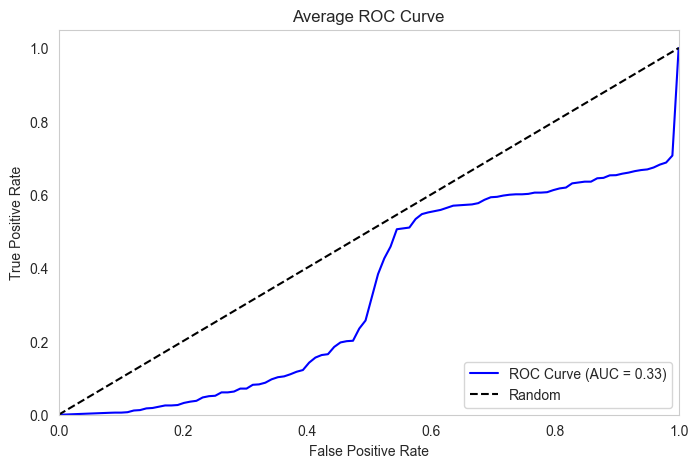

In [839]:
inf_model = ORCA(in_channels=X_train.shape[1], conv_out_channels=64, gat_heads=8)
inf_snapshot = SnapshotManager(inf_model)
inf_snapshot.load_latest()

predictions, probabilities, y_true = evaluate_model(inf_model, test_dataloader)

assert predictions.shape[0] == y_true.shape[0]

accuracy, precision, recall, f1, brier, roc_auc, hamming = calculate_metrics(predictions, probabilities, y_true)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Hamming: {hamming:.4f}")

plot_roc_auc(probabilities, y_true)